In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, EngFormatter, PercentFormatter
import plotly.express as px
from siuba.dply.forcats import fct_lump
plt.rcParams['figure.figsize'] = (11,7)
pd.set_option('display.max_columns',20)

In [2]:
students = pd.read_csv("../data/students_processed_cats.csv")

In [3]:
students.head()

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,nationality,mother's_qualification,father's_qualification,mother's_occupation,...,curricular_units_2nd_sem_(credited),curricular_units_2nd_sem_(enrolled),curricular_units_2nd_sem_(evaluations),curricular_units_2nd_sem_(approved),curricular_units_2nd_sem_(grade),curricular_units_2nd_sem_(without_evaluations),unemployment_rate,inflation_rate,gdp,target
0,Single,2nd phase - general contingent,5,Animation and Multimedia Design,daytime,Secondary education,Portuguese,General commerce course,Other - 11th Year of Schooling,"Personal Services, Security and Safety Workers...",...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,Single,International student (bachelor),1,Tourism,daytime,Secondary education,Portuguese,Secondary Education - 12th Year of Schooling o...,Higher Education - Degree,Intermediate Level Technicians and Professions,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,Single,1st phase - general contingent,5,Communication Design,daytime,Secondary education,Portuguese,General Course of Administration and Commerce,Basic education 1st cycle (4th/5th year),Unskilled Workers,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,Single,2nd phase - general contingent,2,Journalism and Communication,daytime,Secondary education,Portuguese,Supplementary Accounting and Administration,Basic education 1st cycle (4th/5th year),"Personal Services, Security and Safety Workers...",...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,Married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary education,Portuguese,General Course of Administration and Commerce,Basic Education 2nd Cycle (6th/7th/8th Year),Unskilled Workers,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Target variable

In [4]:
students.target.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

Transform this column to order categorical

In [5]:
target_order = ["Dropout", "Enrolled", "Graduate"]
students["target"] = students['target'].astype("category").cat.reorder_categories(target_order)

Text(0.5, 1.0, 'Many dropouts in the data')

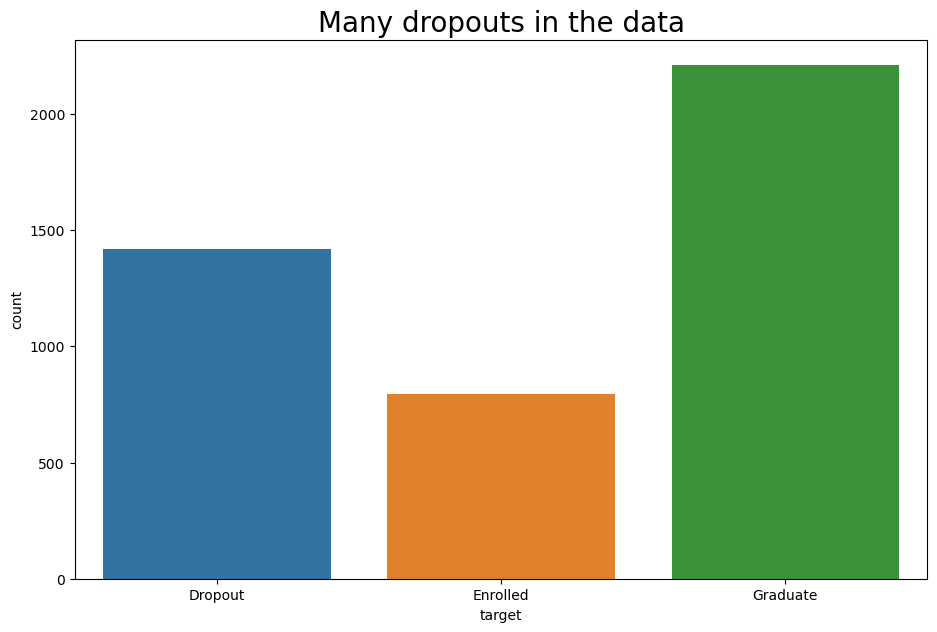

In [6]:
sns.countplot(students, x = "target")
plt.title("Many dropouts in the data", fontsize = 20)

In [7]:
students.target.value_counts(sort = False, normalize=True)

Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: target, dtype: float64

Only 50% of the initial students graduates on time, 32% leave the course and 18% continue studying and the end of the regular course. Almost 1/3 of the total dropout the school.

## Relation of variables to target

In [50]:
def plot_proportions(data, var, size = (13,6)):
    var_title = var.replace("_"," ").title()
    data_filter = data.groupby(var, as_index = False)["target"].value_counts()
    data_filter["proportion"] = data_filter.groupby(var)["count"].transform(lambda x: x / sum(x))
    y_order = data_filter.query("target == 'Graduate'").sort_values("proportion", ascending = False)[var].values
    return (
       so.Plot(data_filter, y = var, color = "target")
       .pair(x = ["proportion", "count"])
       .layout(size = size, engine = "tight")
       .add(so.Bar(), so.Dodge())
       .scale(color=so.Nominal(order=target_order[::-1]),
              y = so.Nominal(order = y_order),
              x0 = so.Continuous().label(like = "{x:.0%}"))
       .label(y = var_title,
              x0 = lambda x: x.title(),
              x1 = lambda x: x.title(),
              color = "Target")
       .theme({**axes_style("white")})
    )

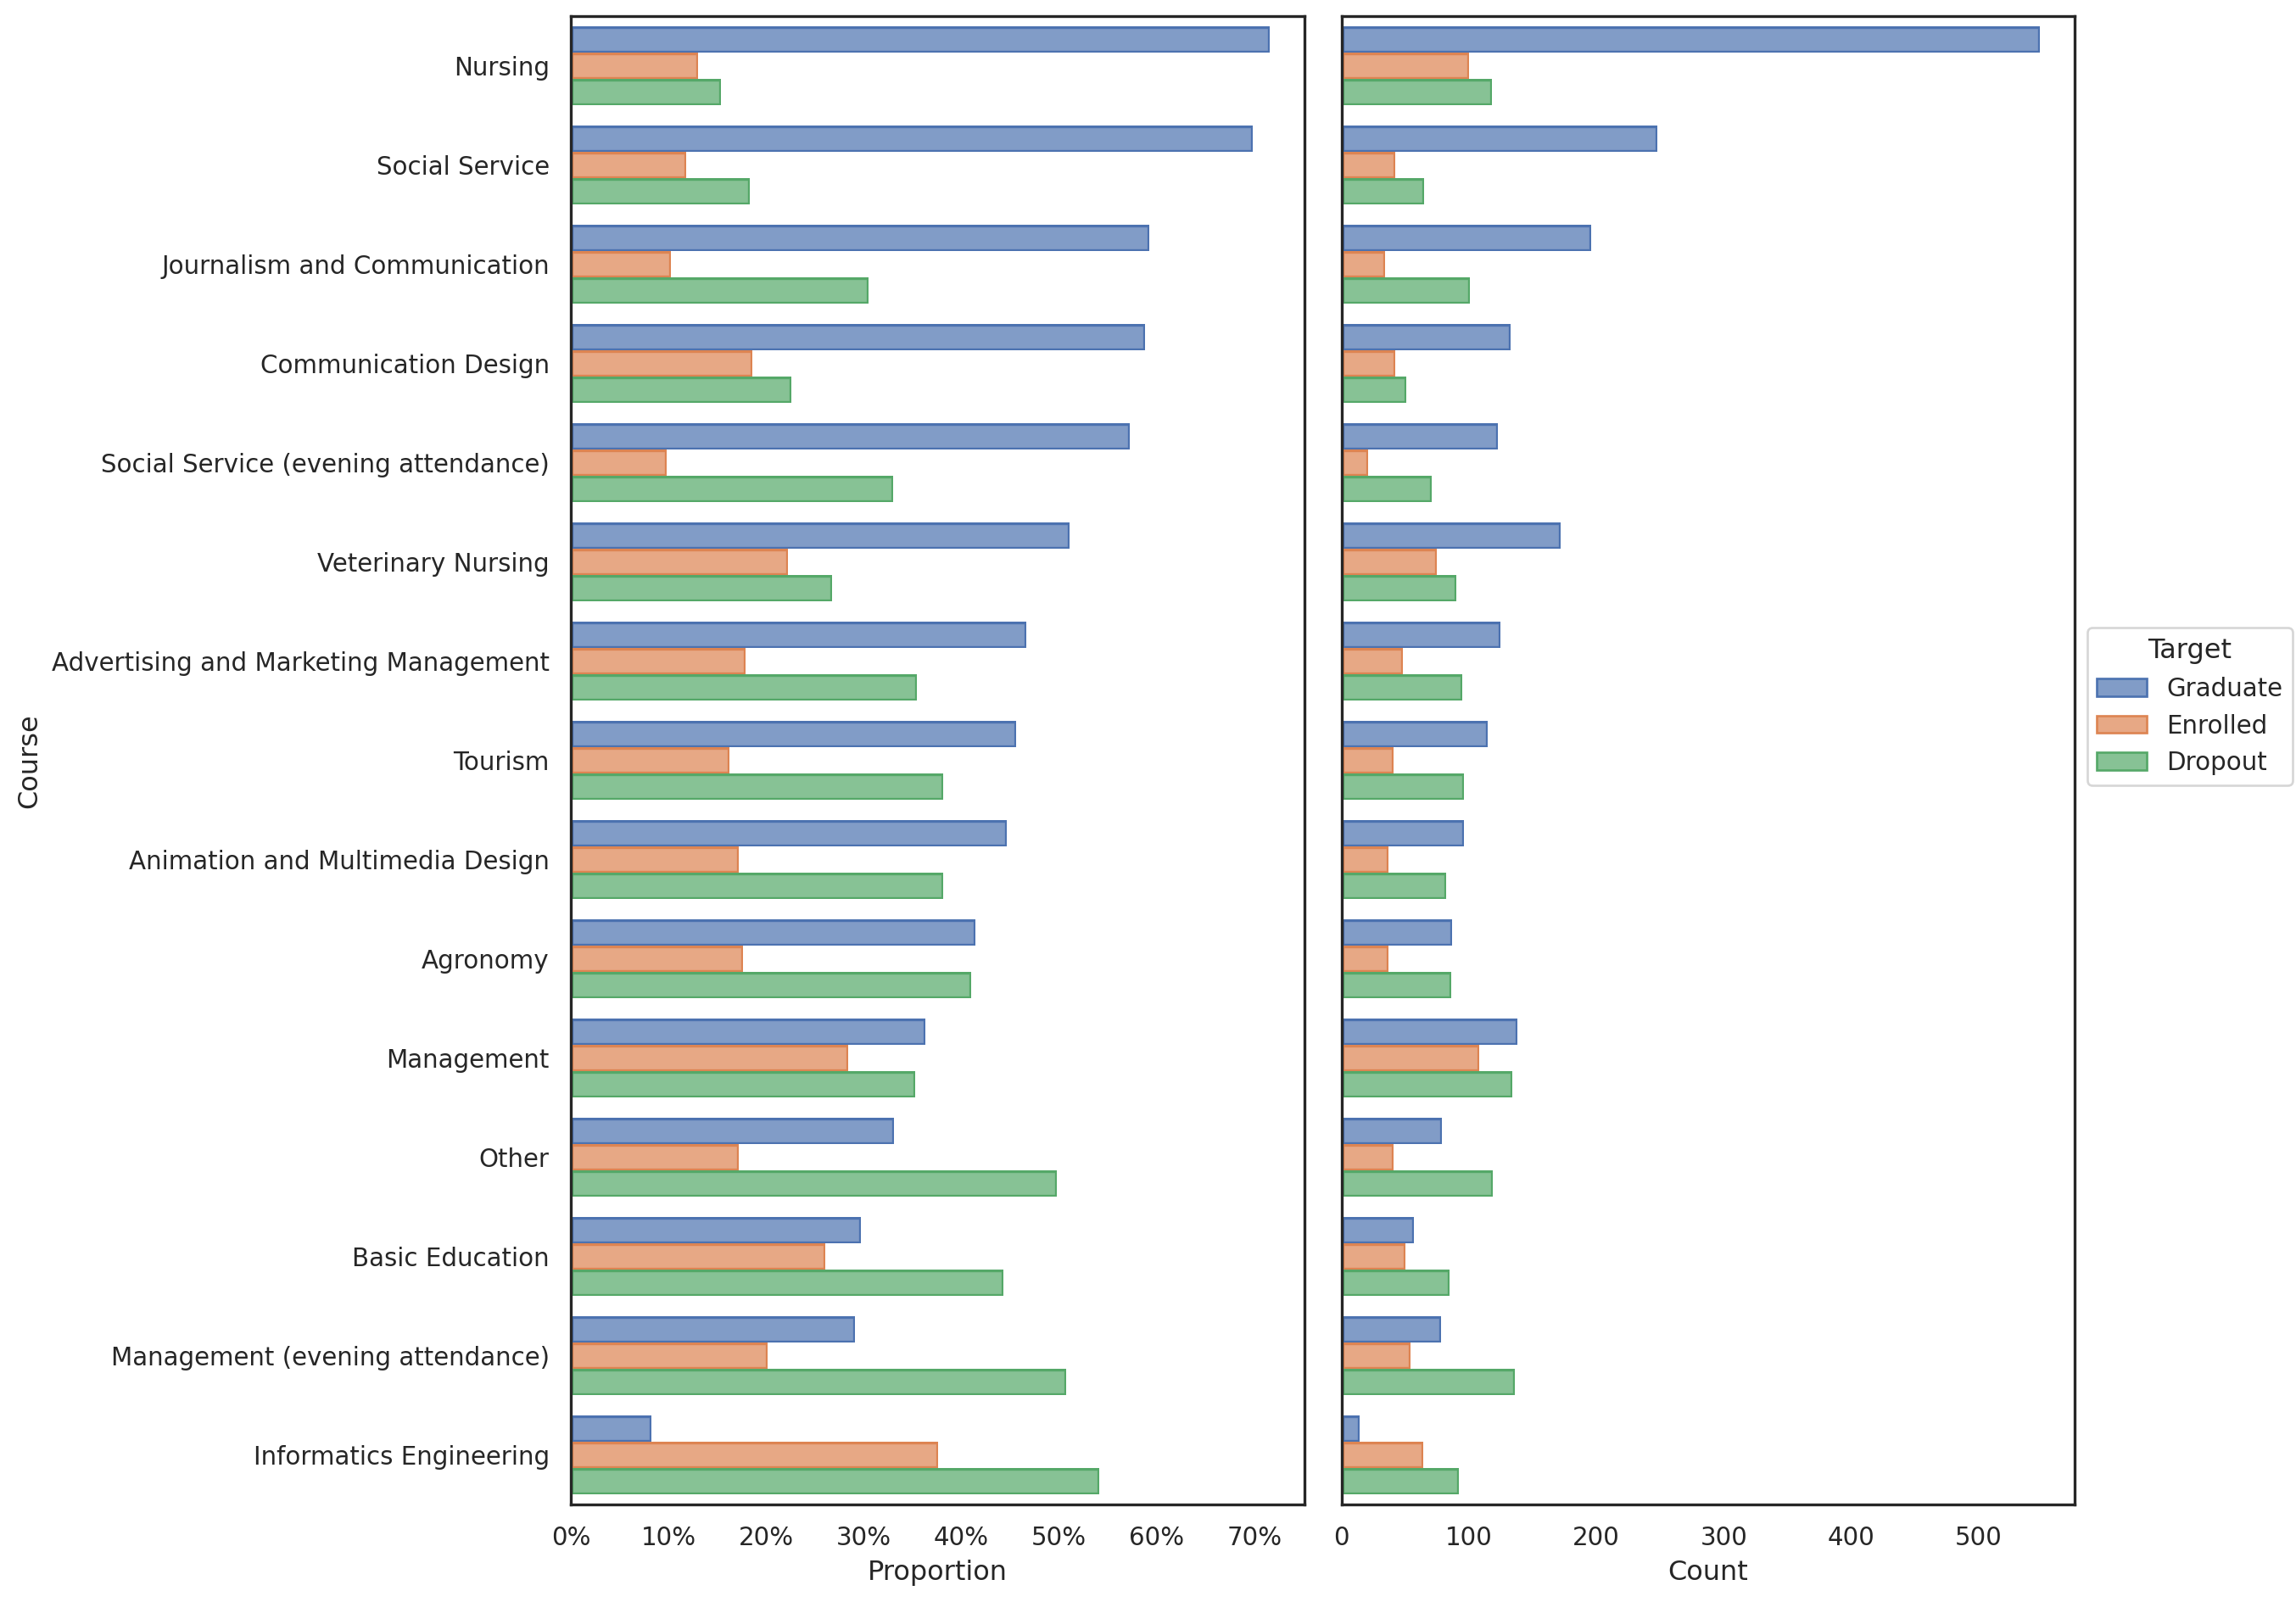

In [48]:
students.assign(course = lambda x: fct_lump(x.course, 14)).pipe(plot_proportions, "course", (13,10))

The course have a strong correlation with graduation rate. In the nursing course, 70% of the total students graduate, while less than 10% graduates in informatics engineering

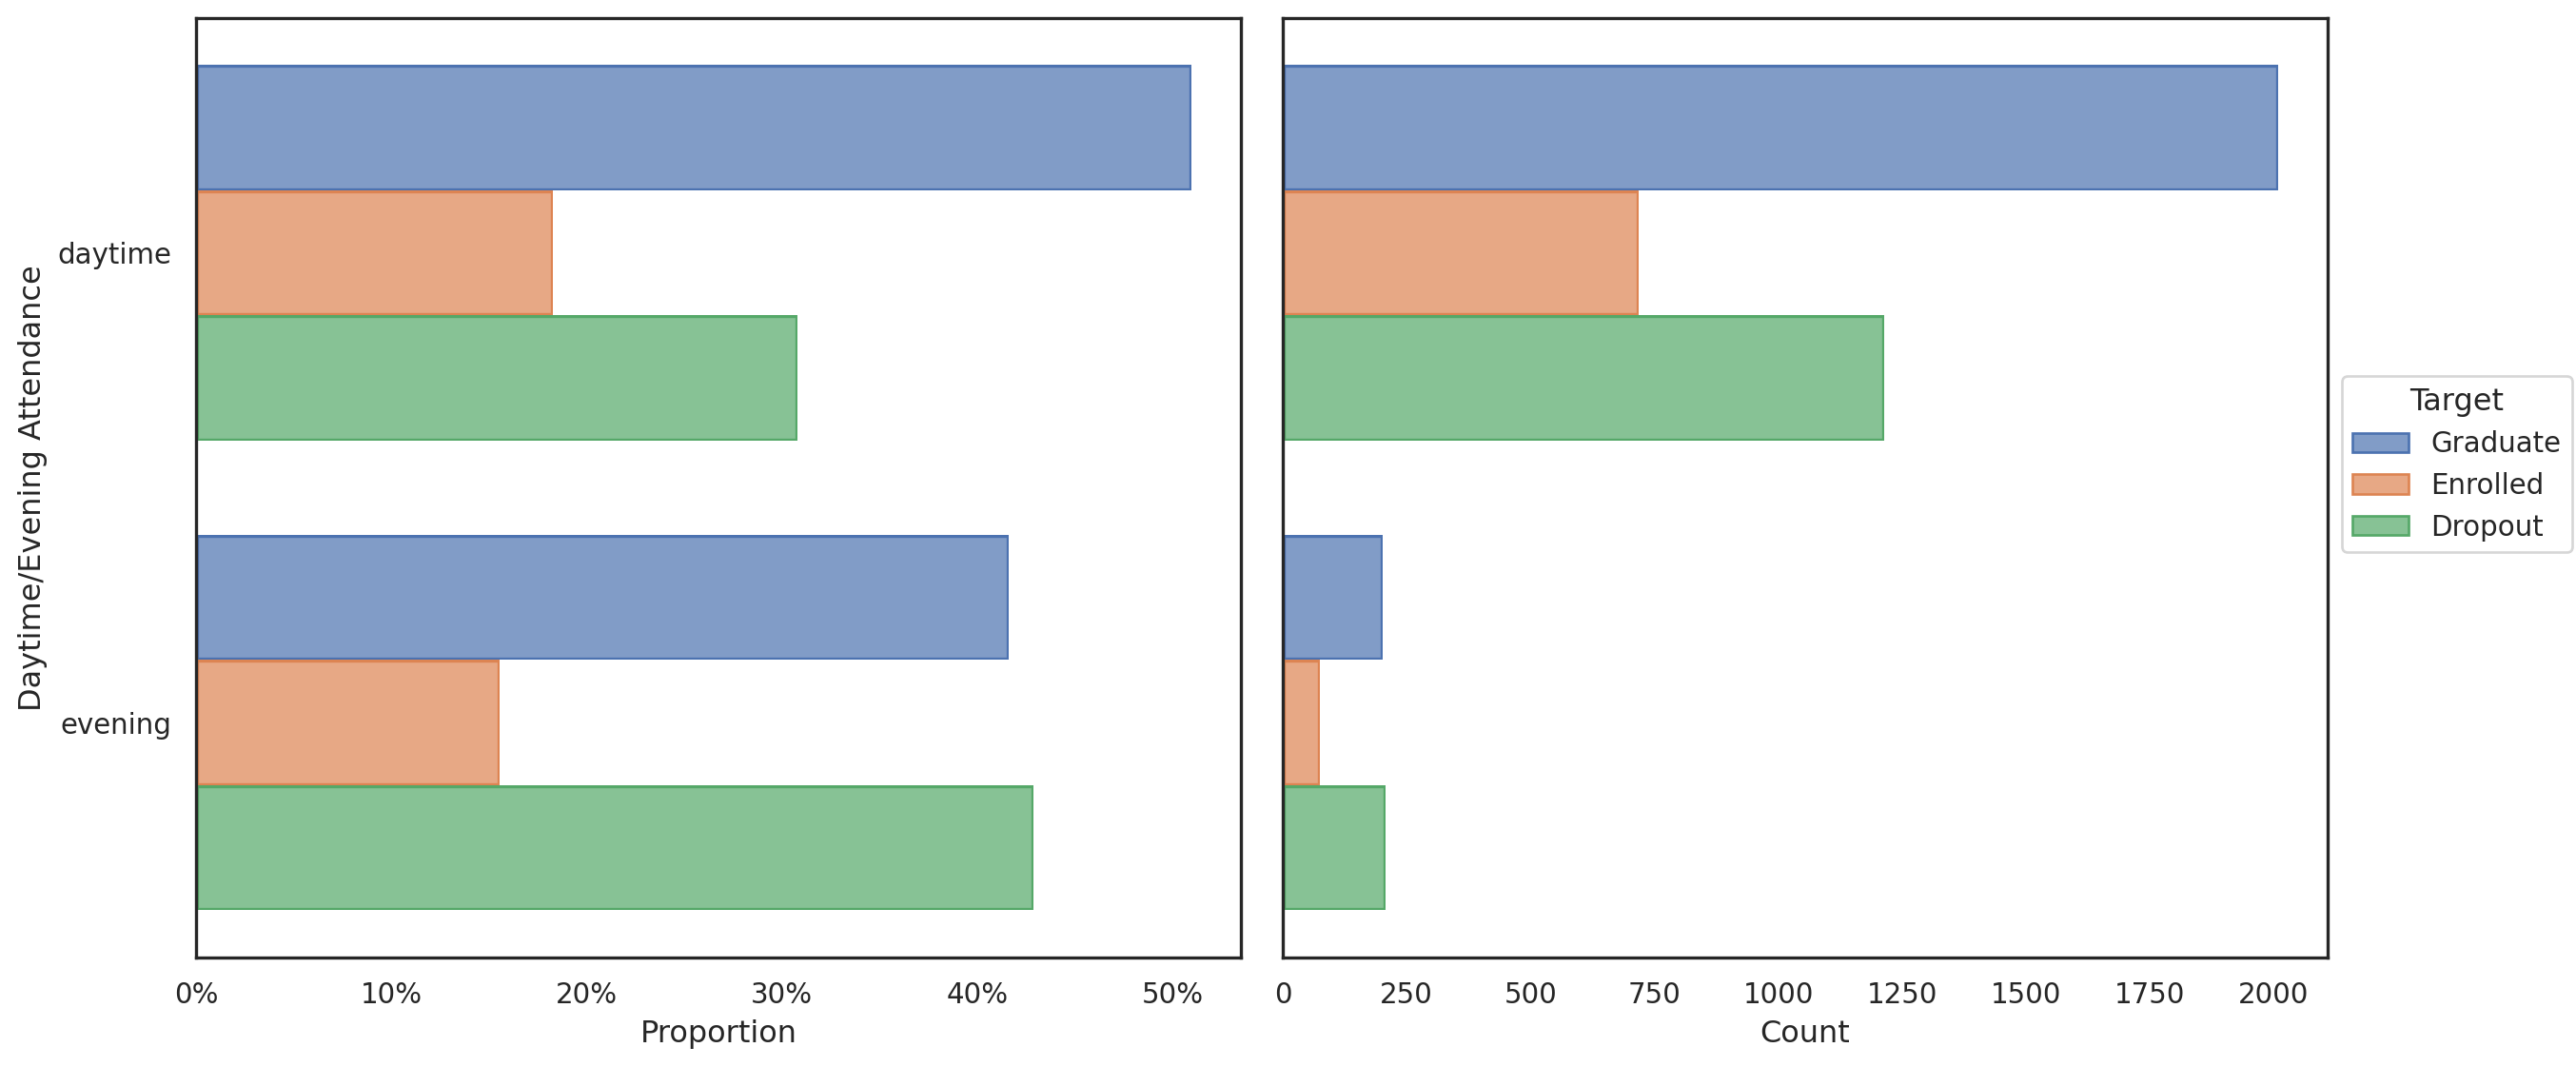

In [51]:
students.pipe(plot_proportions, "daytime/evening_attendance")

Daytime students are more likely to graduate, the majority of the evening students dropout

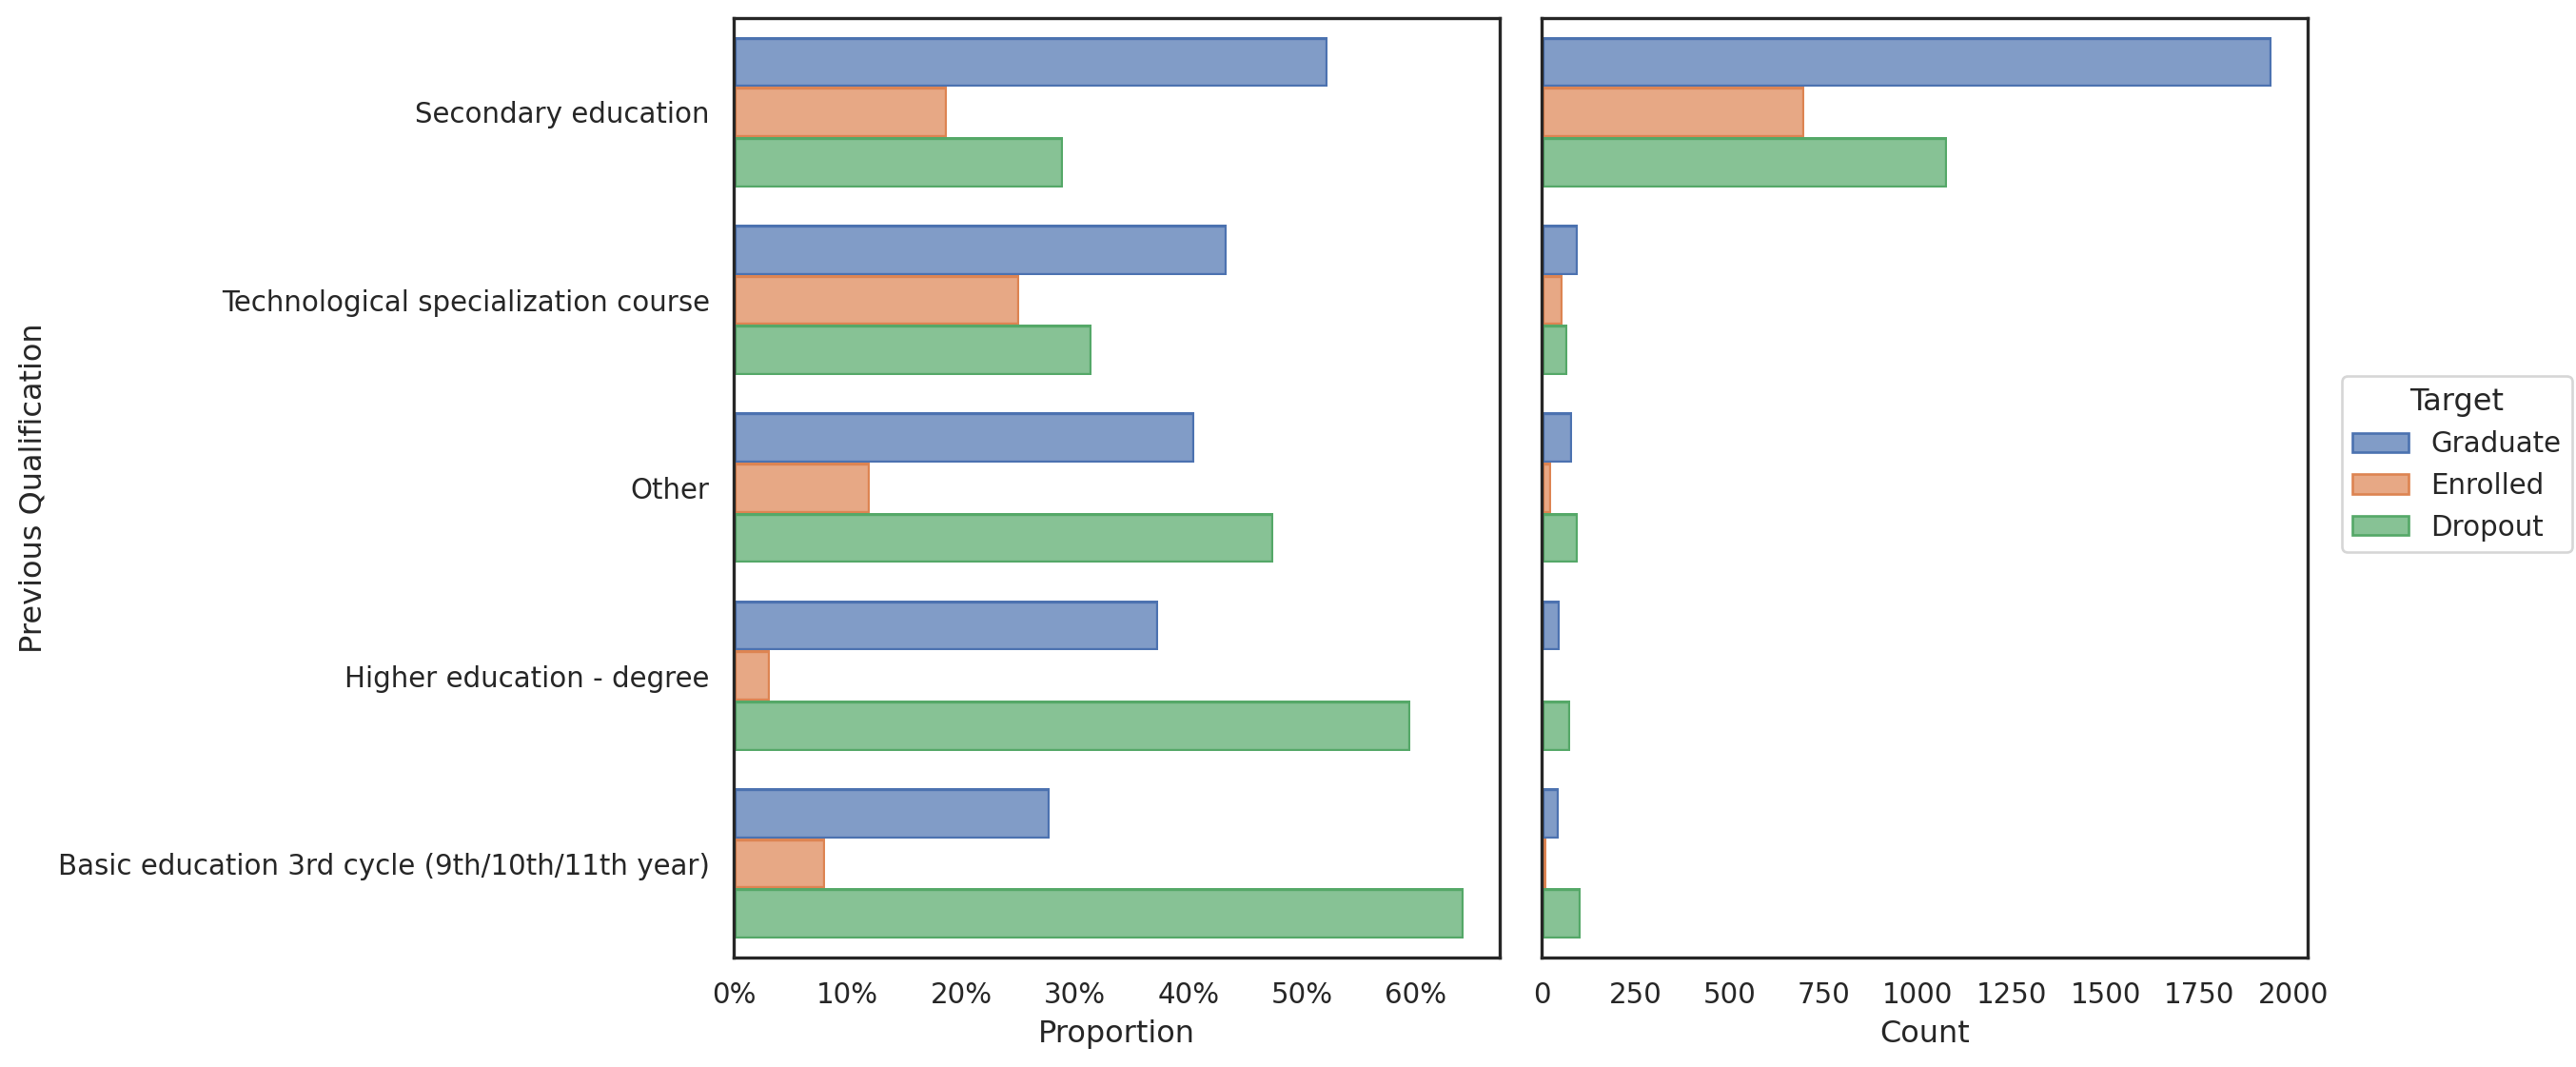

In [52]:
(students
 .assign(previous_qualification = lambda x: fct_lump(x.previous_qualification, 4))
 .pipe(plot_proportions, "previous_qualification")
)

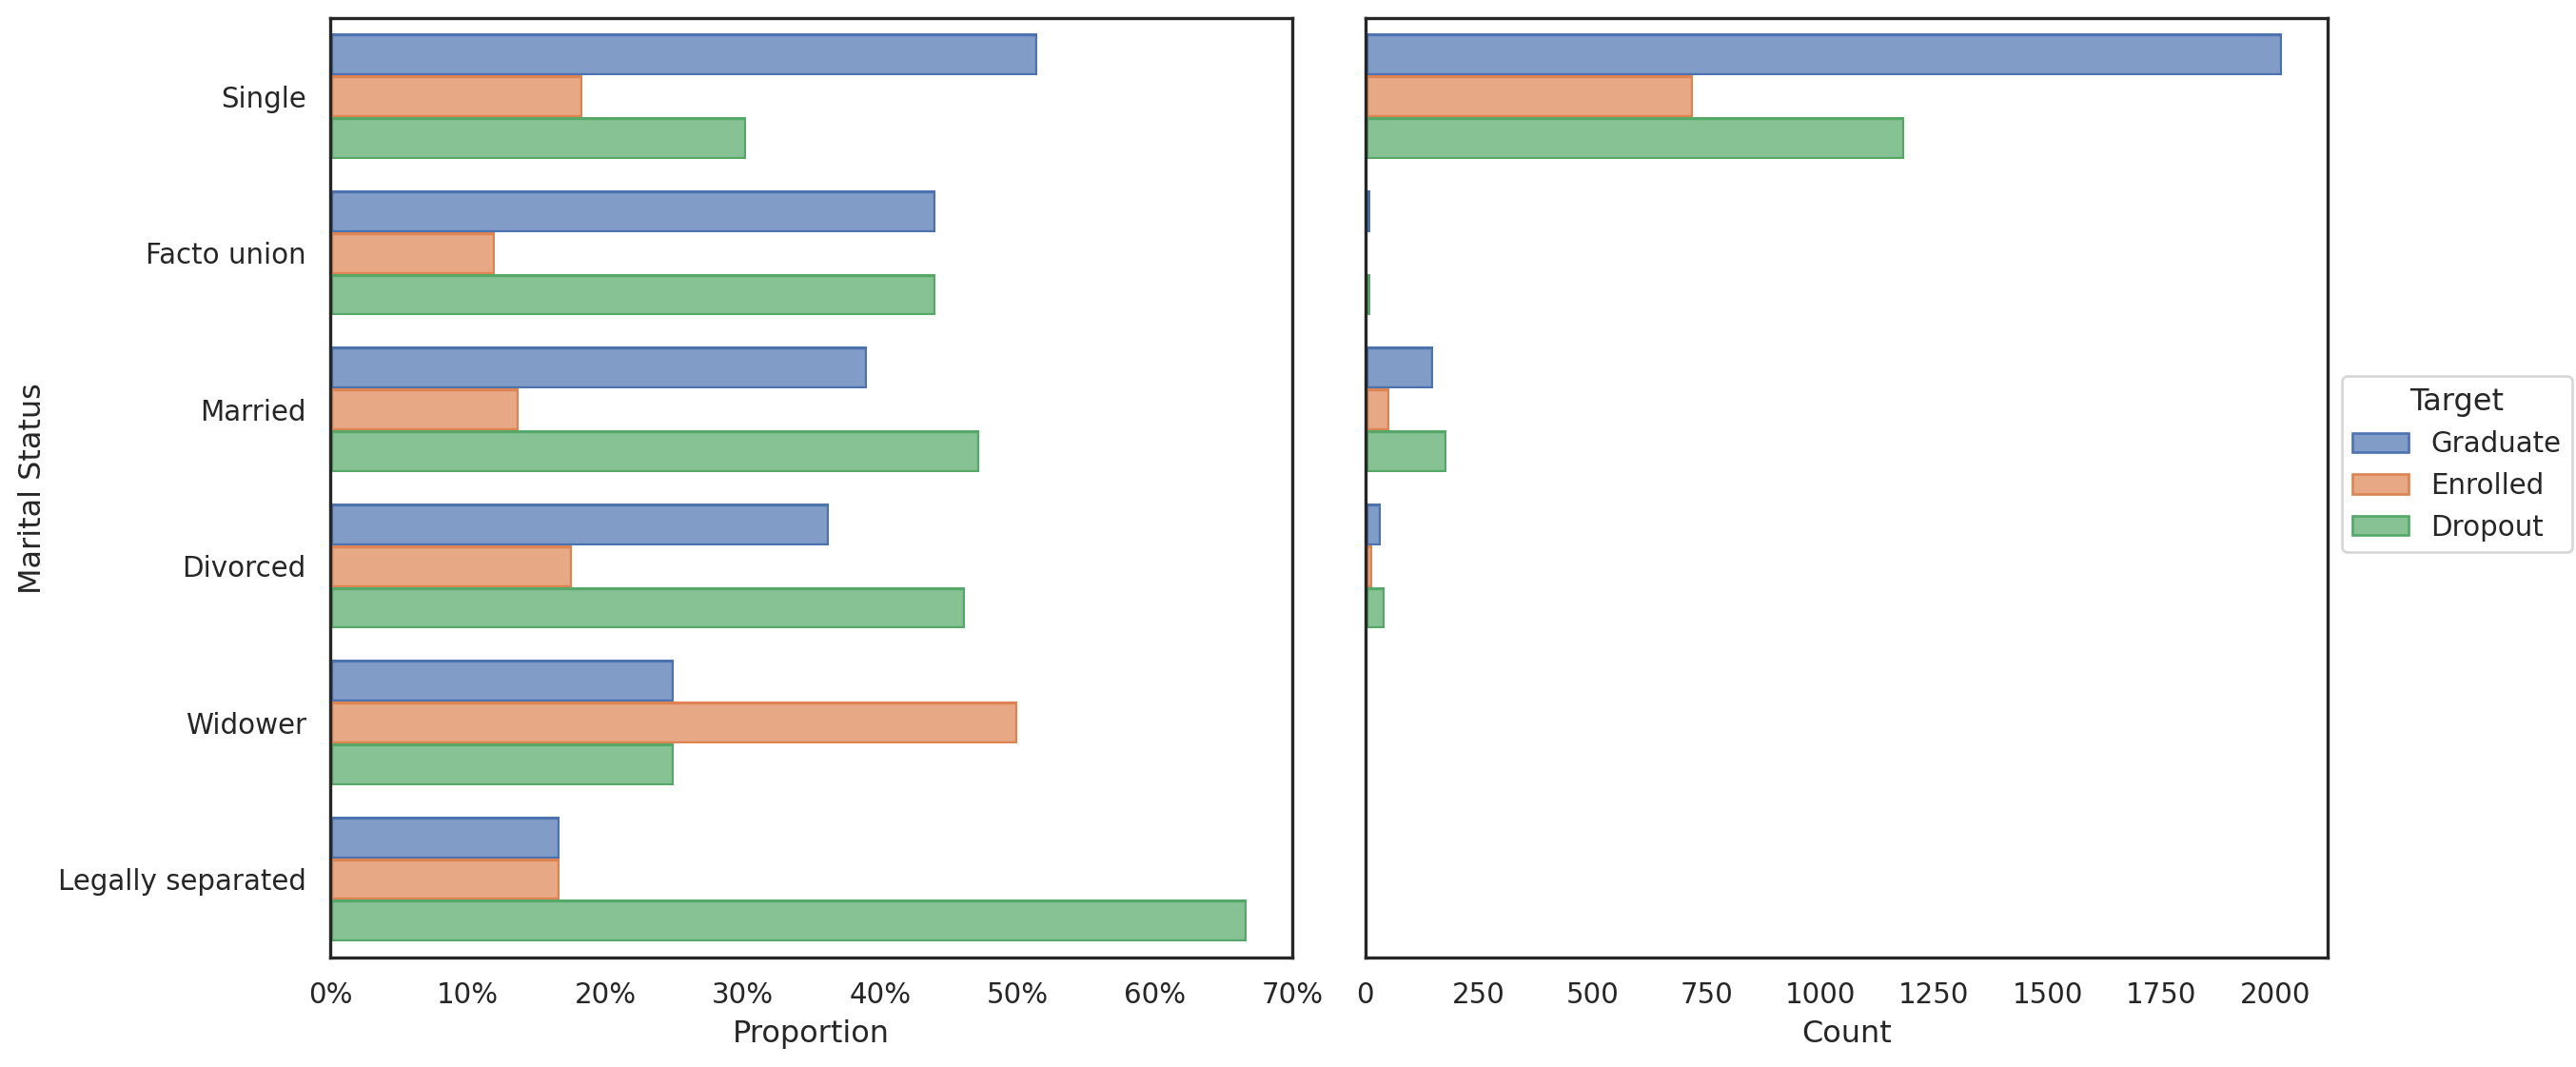

In [53]:
students.pipe(plot_proportions, "marital_status")

The big majority of the students are single (more than 80% of the total)

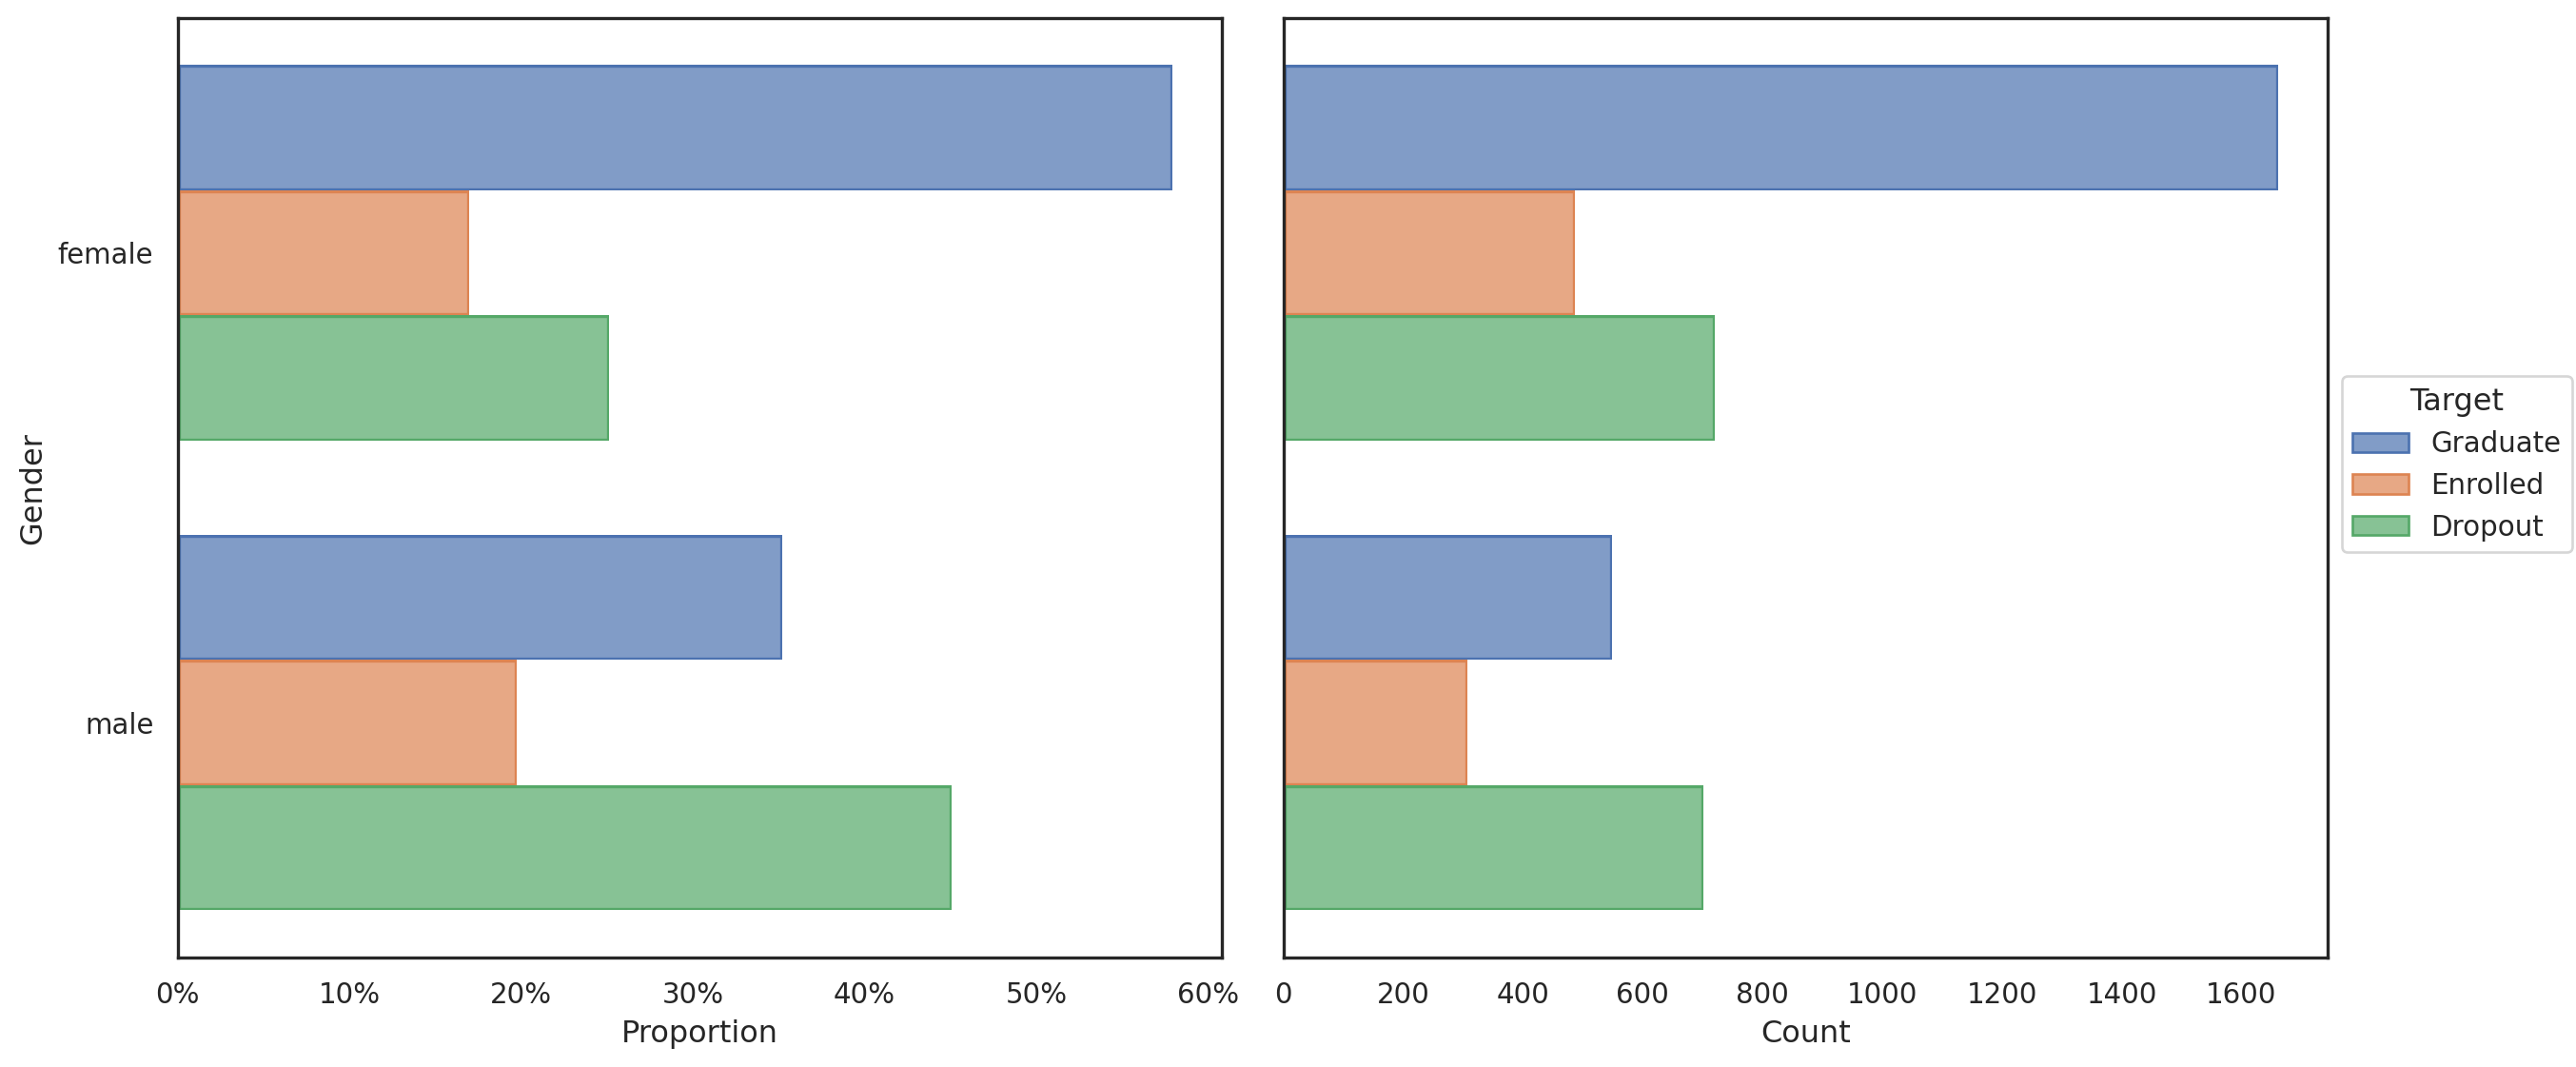

In [54]:
students.pipe(plot_proportions, "gender")

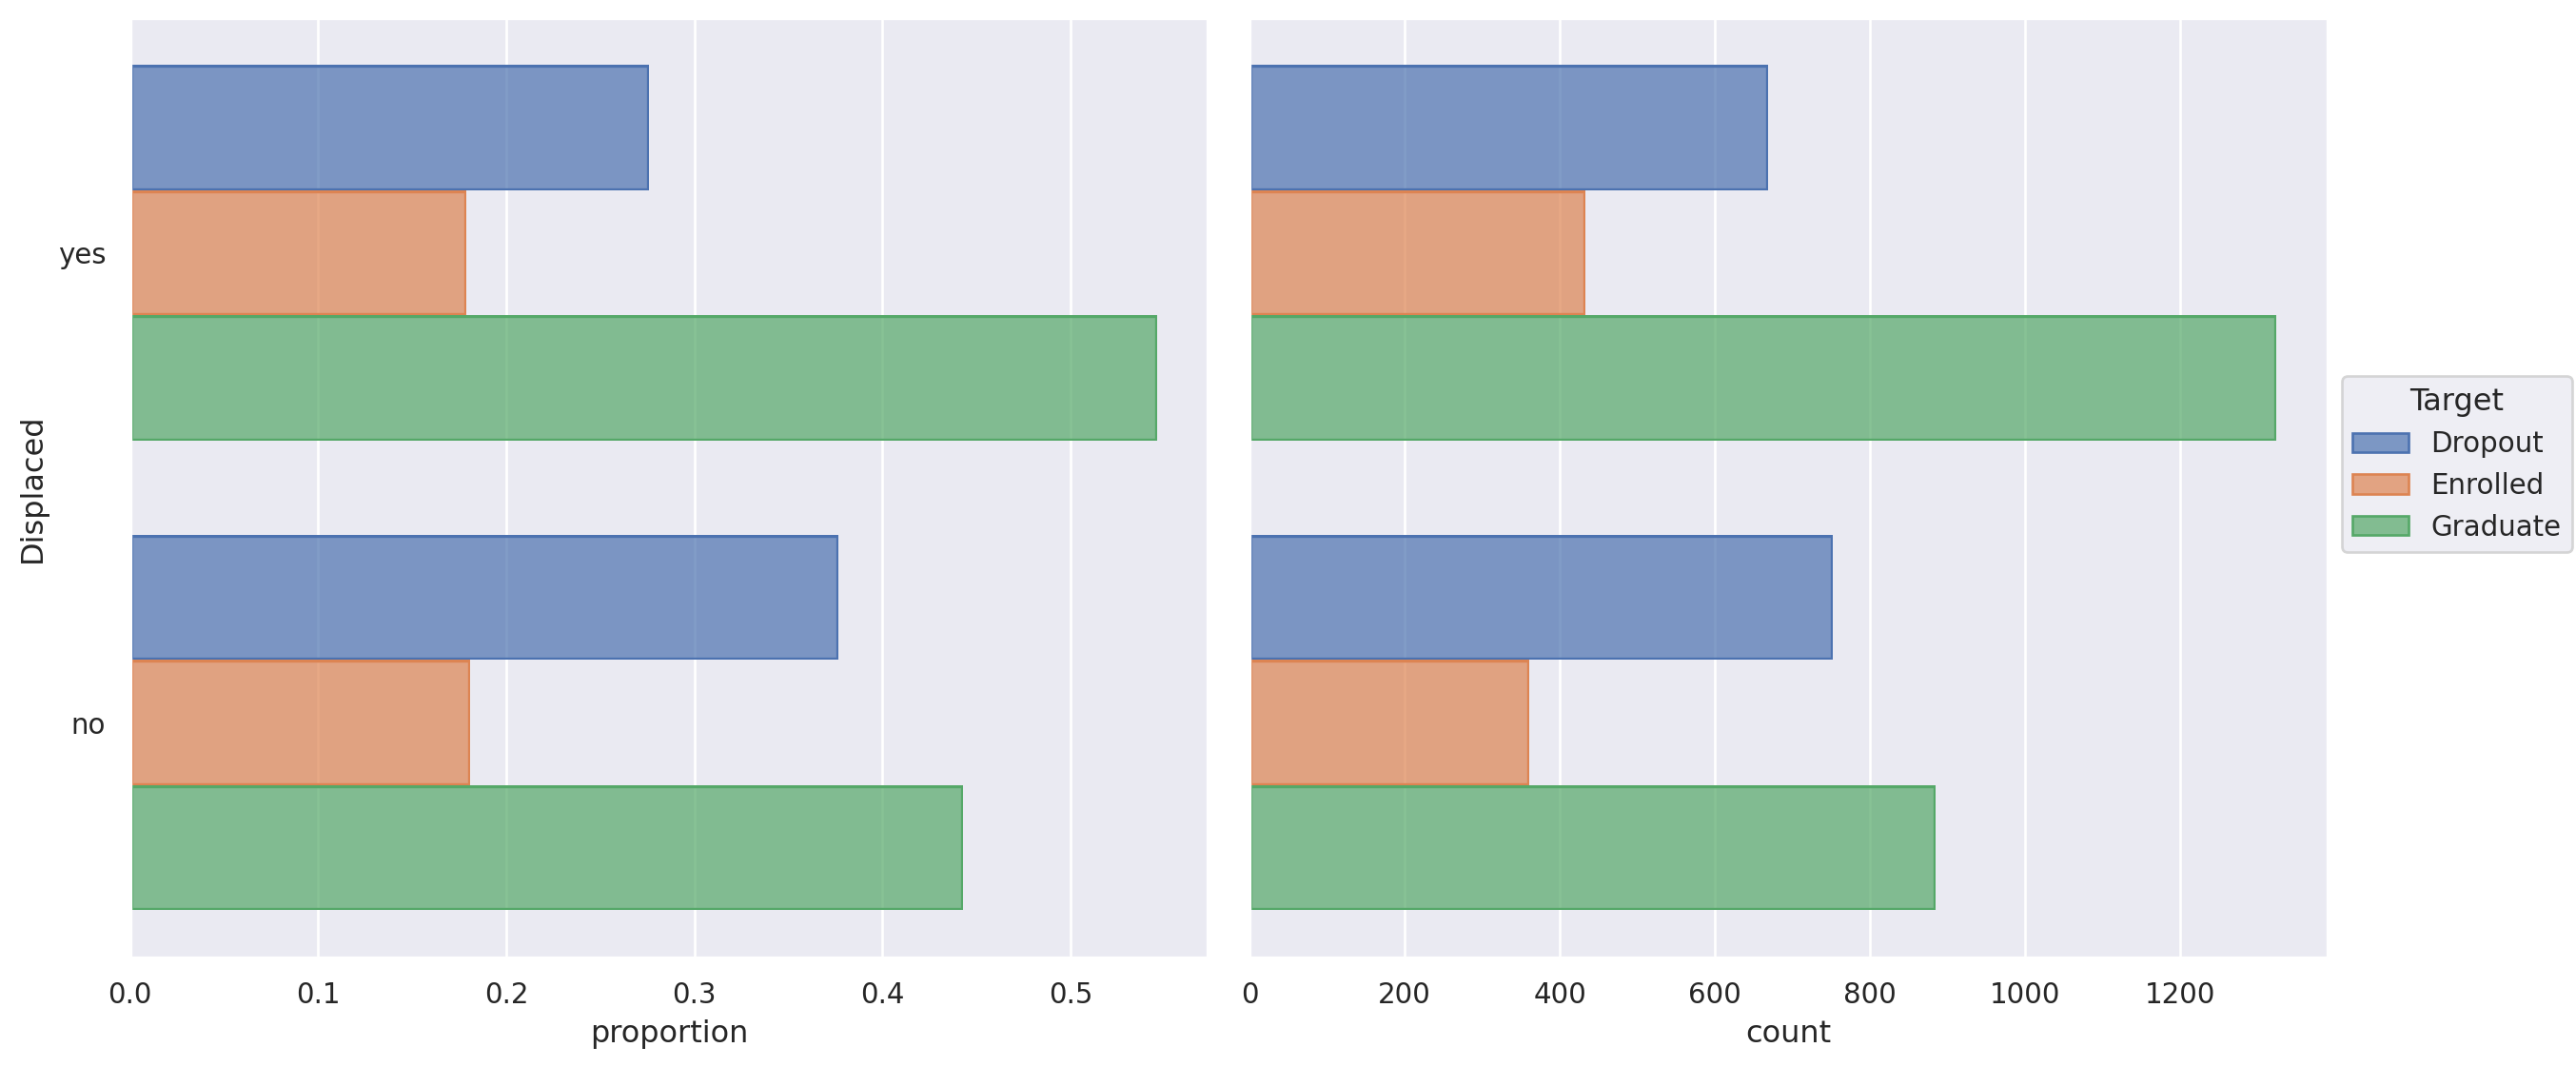

In [141]:
students.pipe(plot_proportions, "displaced")

Women are 10% more likely to graduate than men

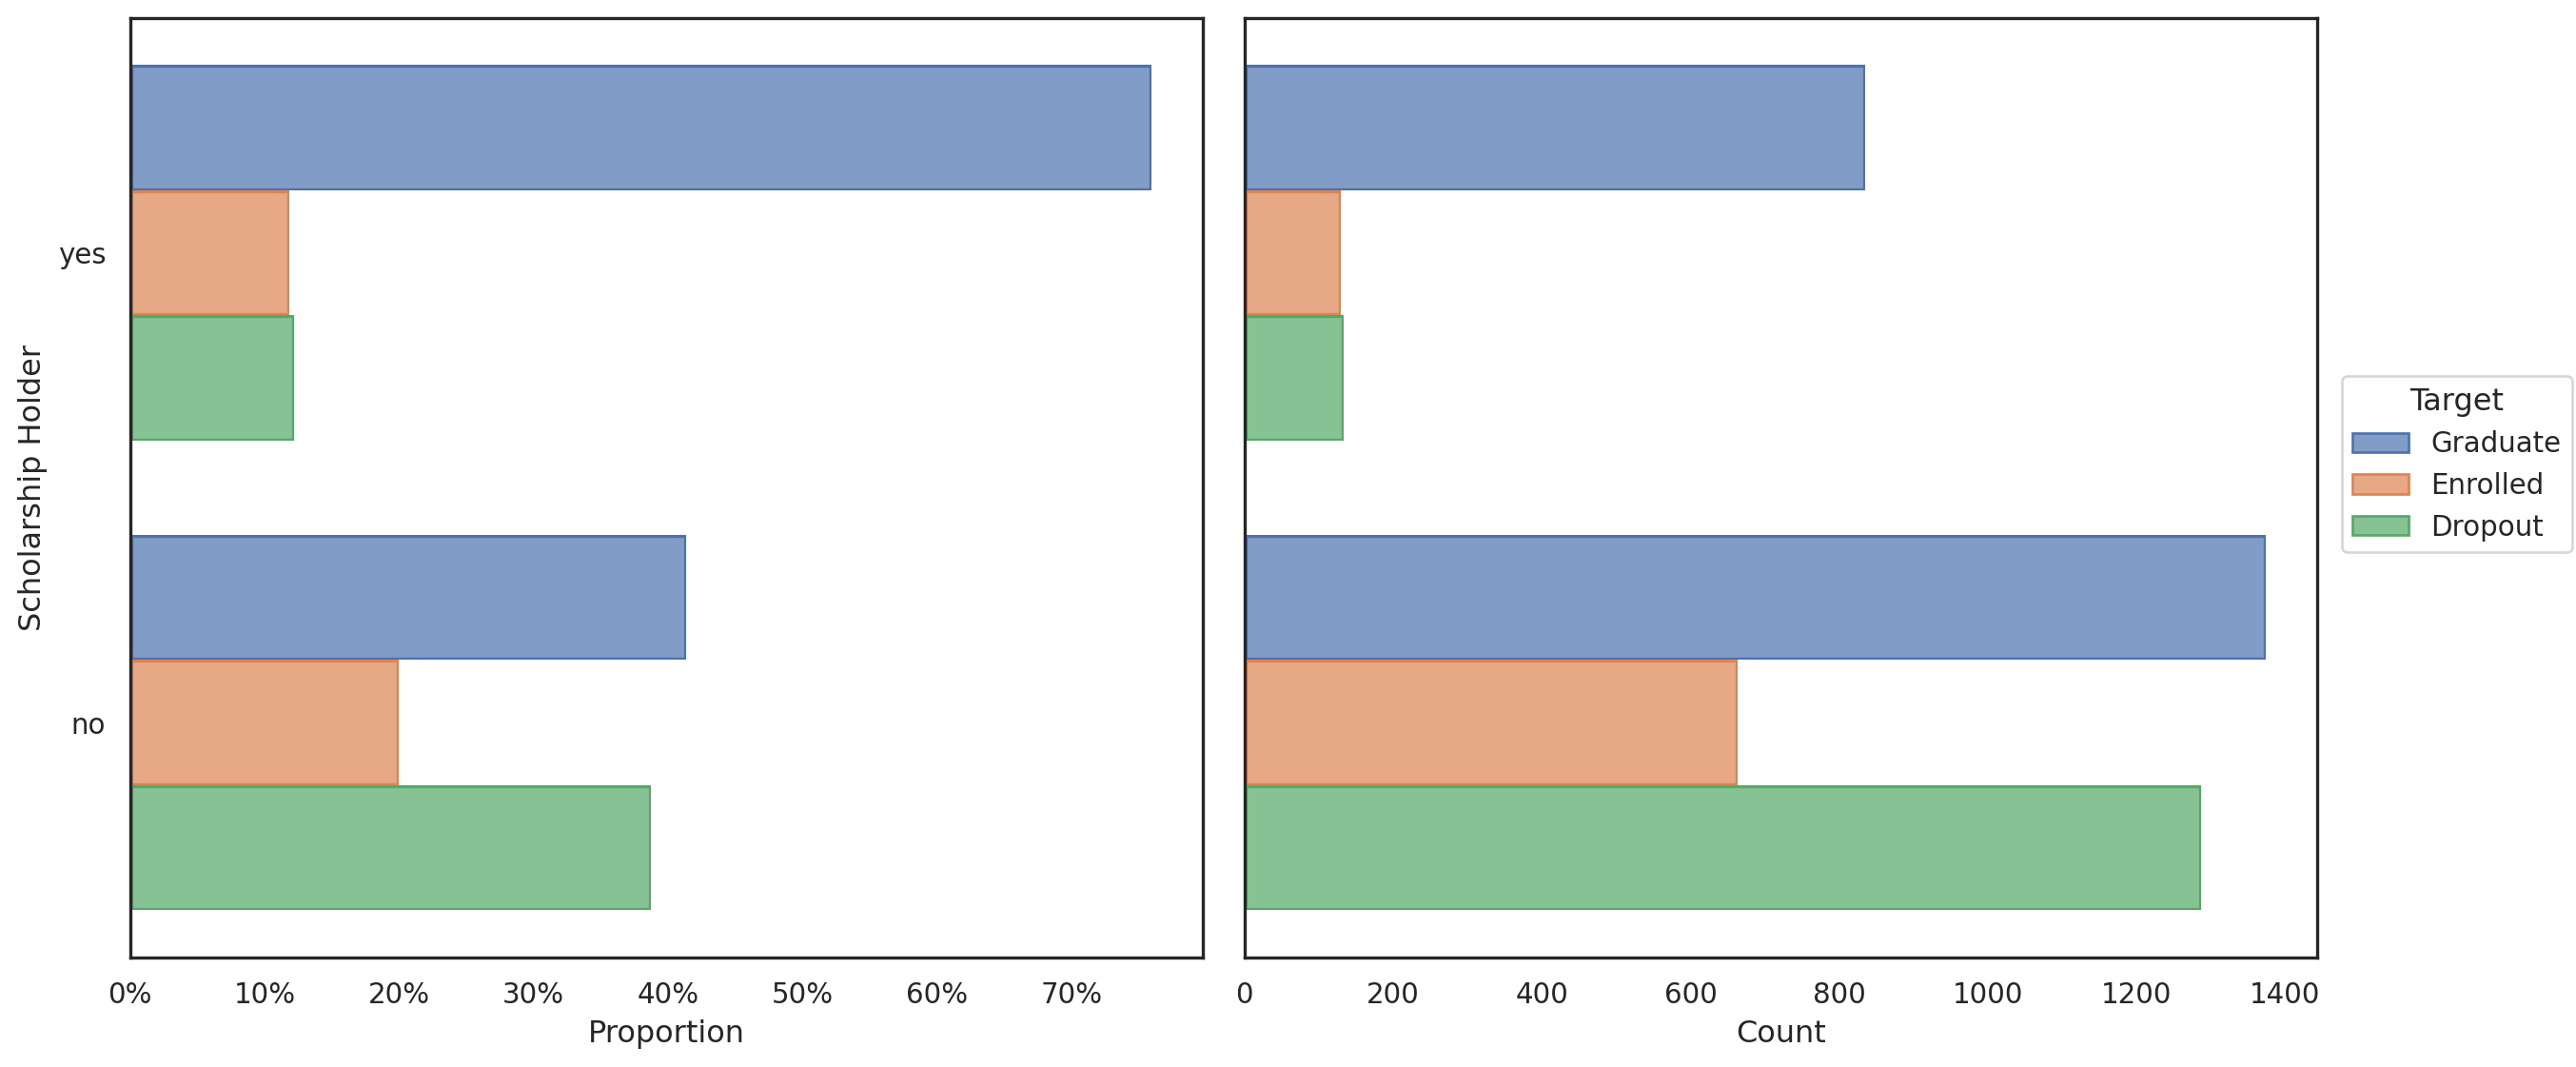

In [55]:
students.pipe(plot_proportions, "scholarship_holder")

Wow, looks like scholarships are a great predictor of graduation, but correlation is not causation. Are scholarships making students more likely to graduate or is it that students that get scholarships are those with better grades and that is causing the higher graduation rate? I will dig up into this subject later

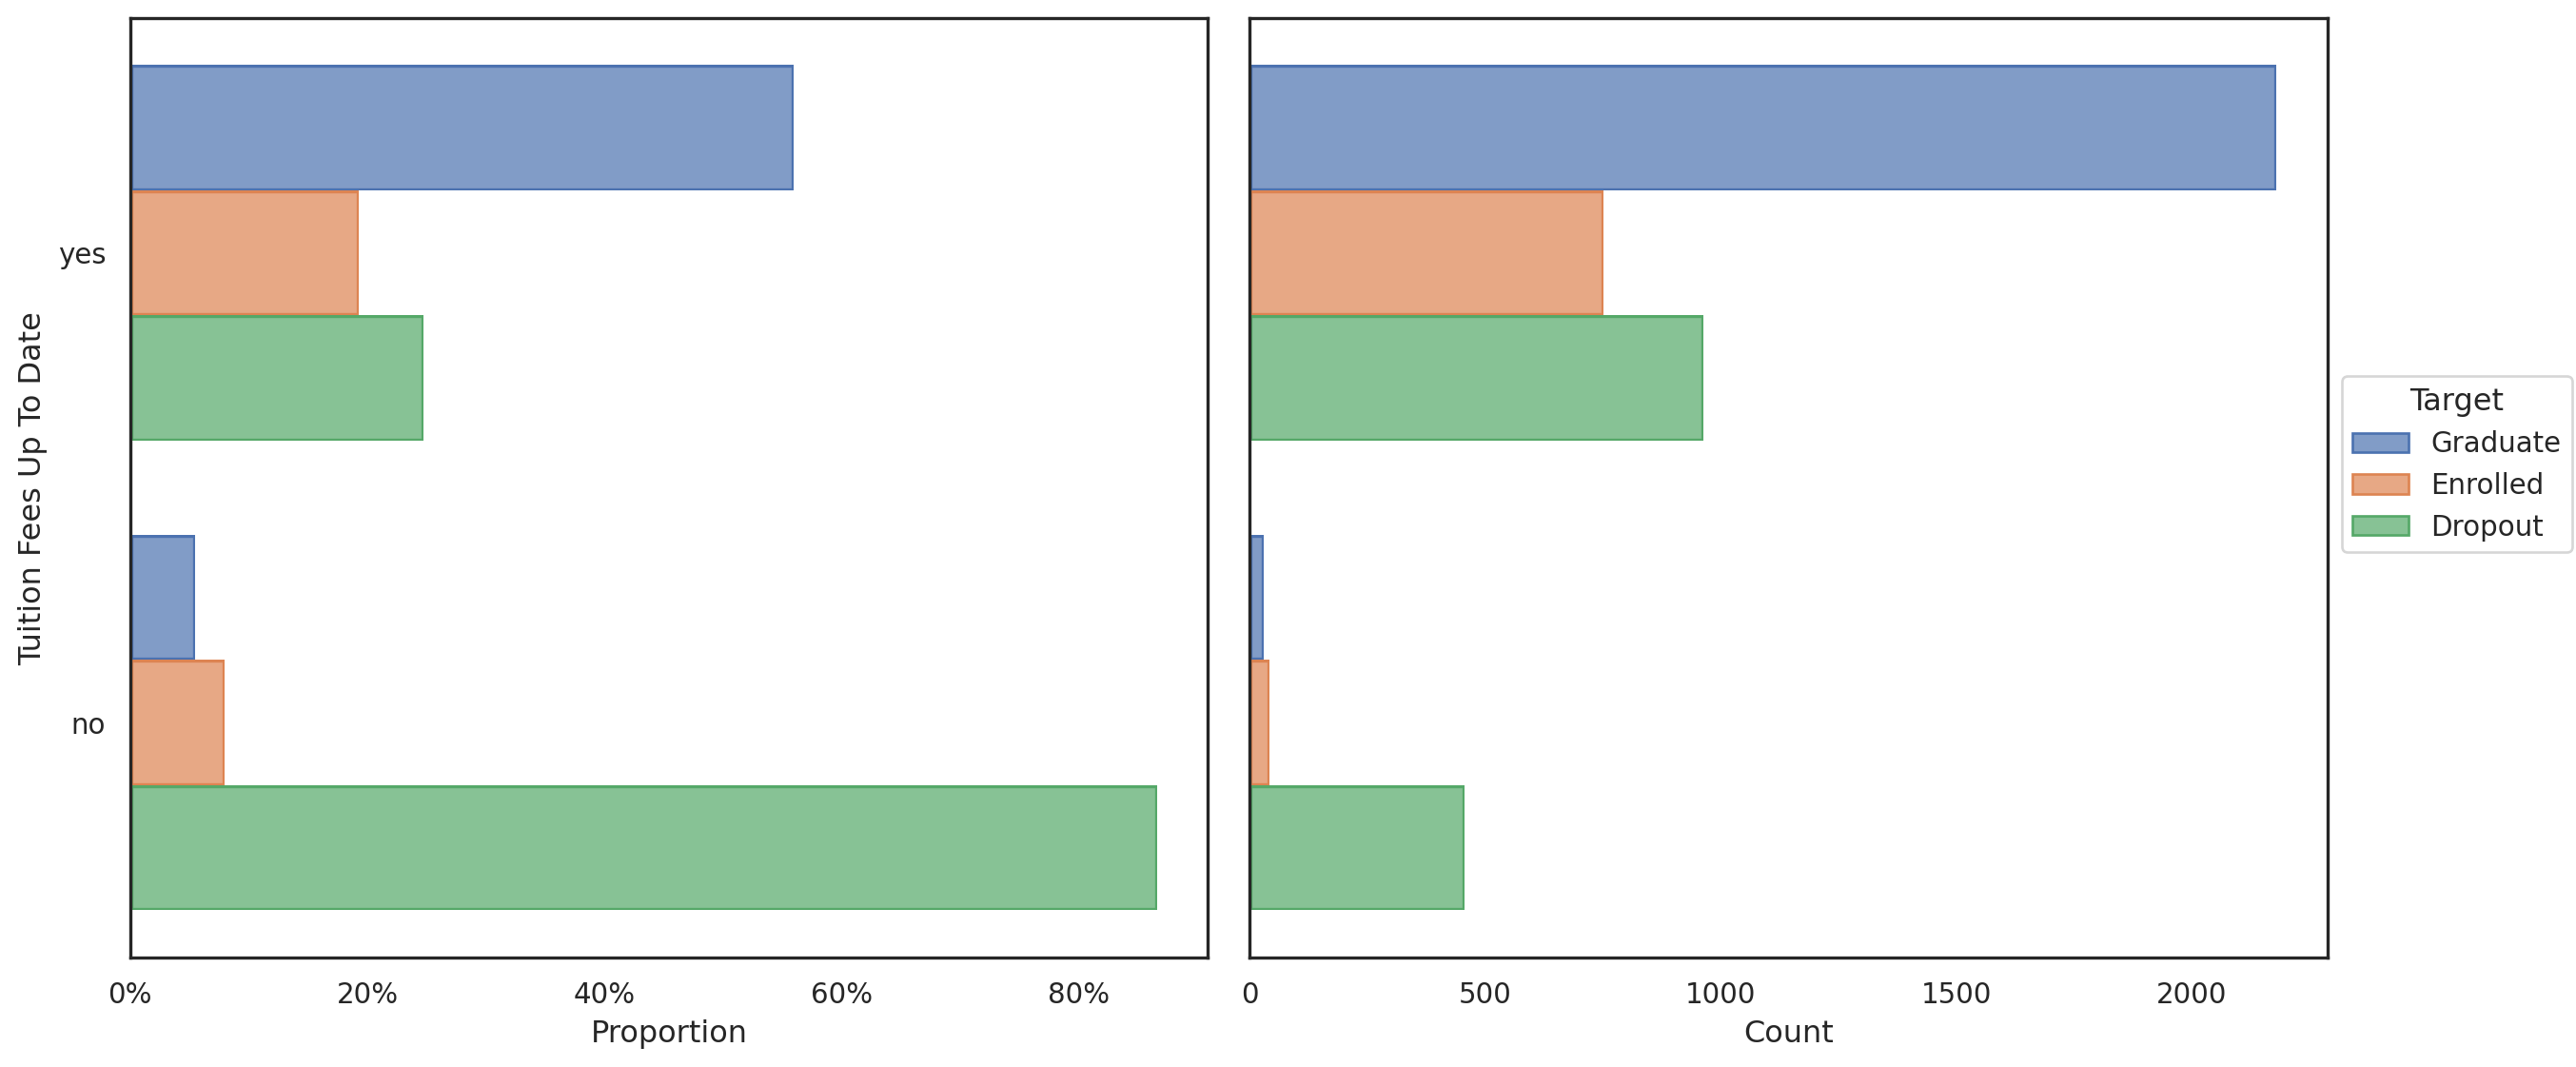

In [56]:
students.pipe(plot_proportions, "tuition_fees_up_to_date")

Those who don't have their tuition fee up to date are really likely (85%) of dropout. This makes sense, once you know you will leave, you stop paying. Probably this is a great indicator for the university, those who stop paying their tuition are really likely to dropout, follow up those cases and check what is happening.

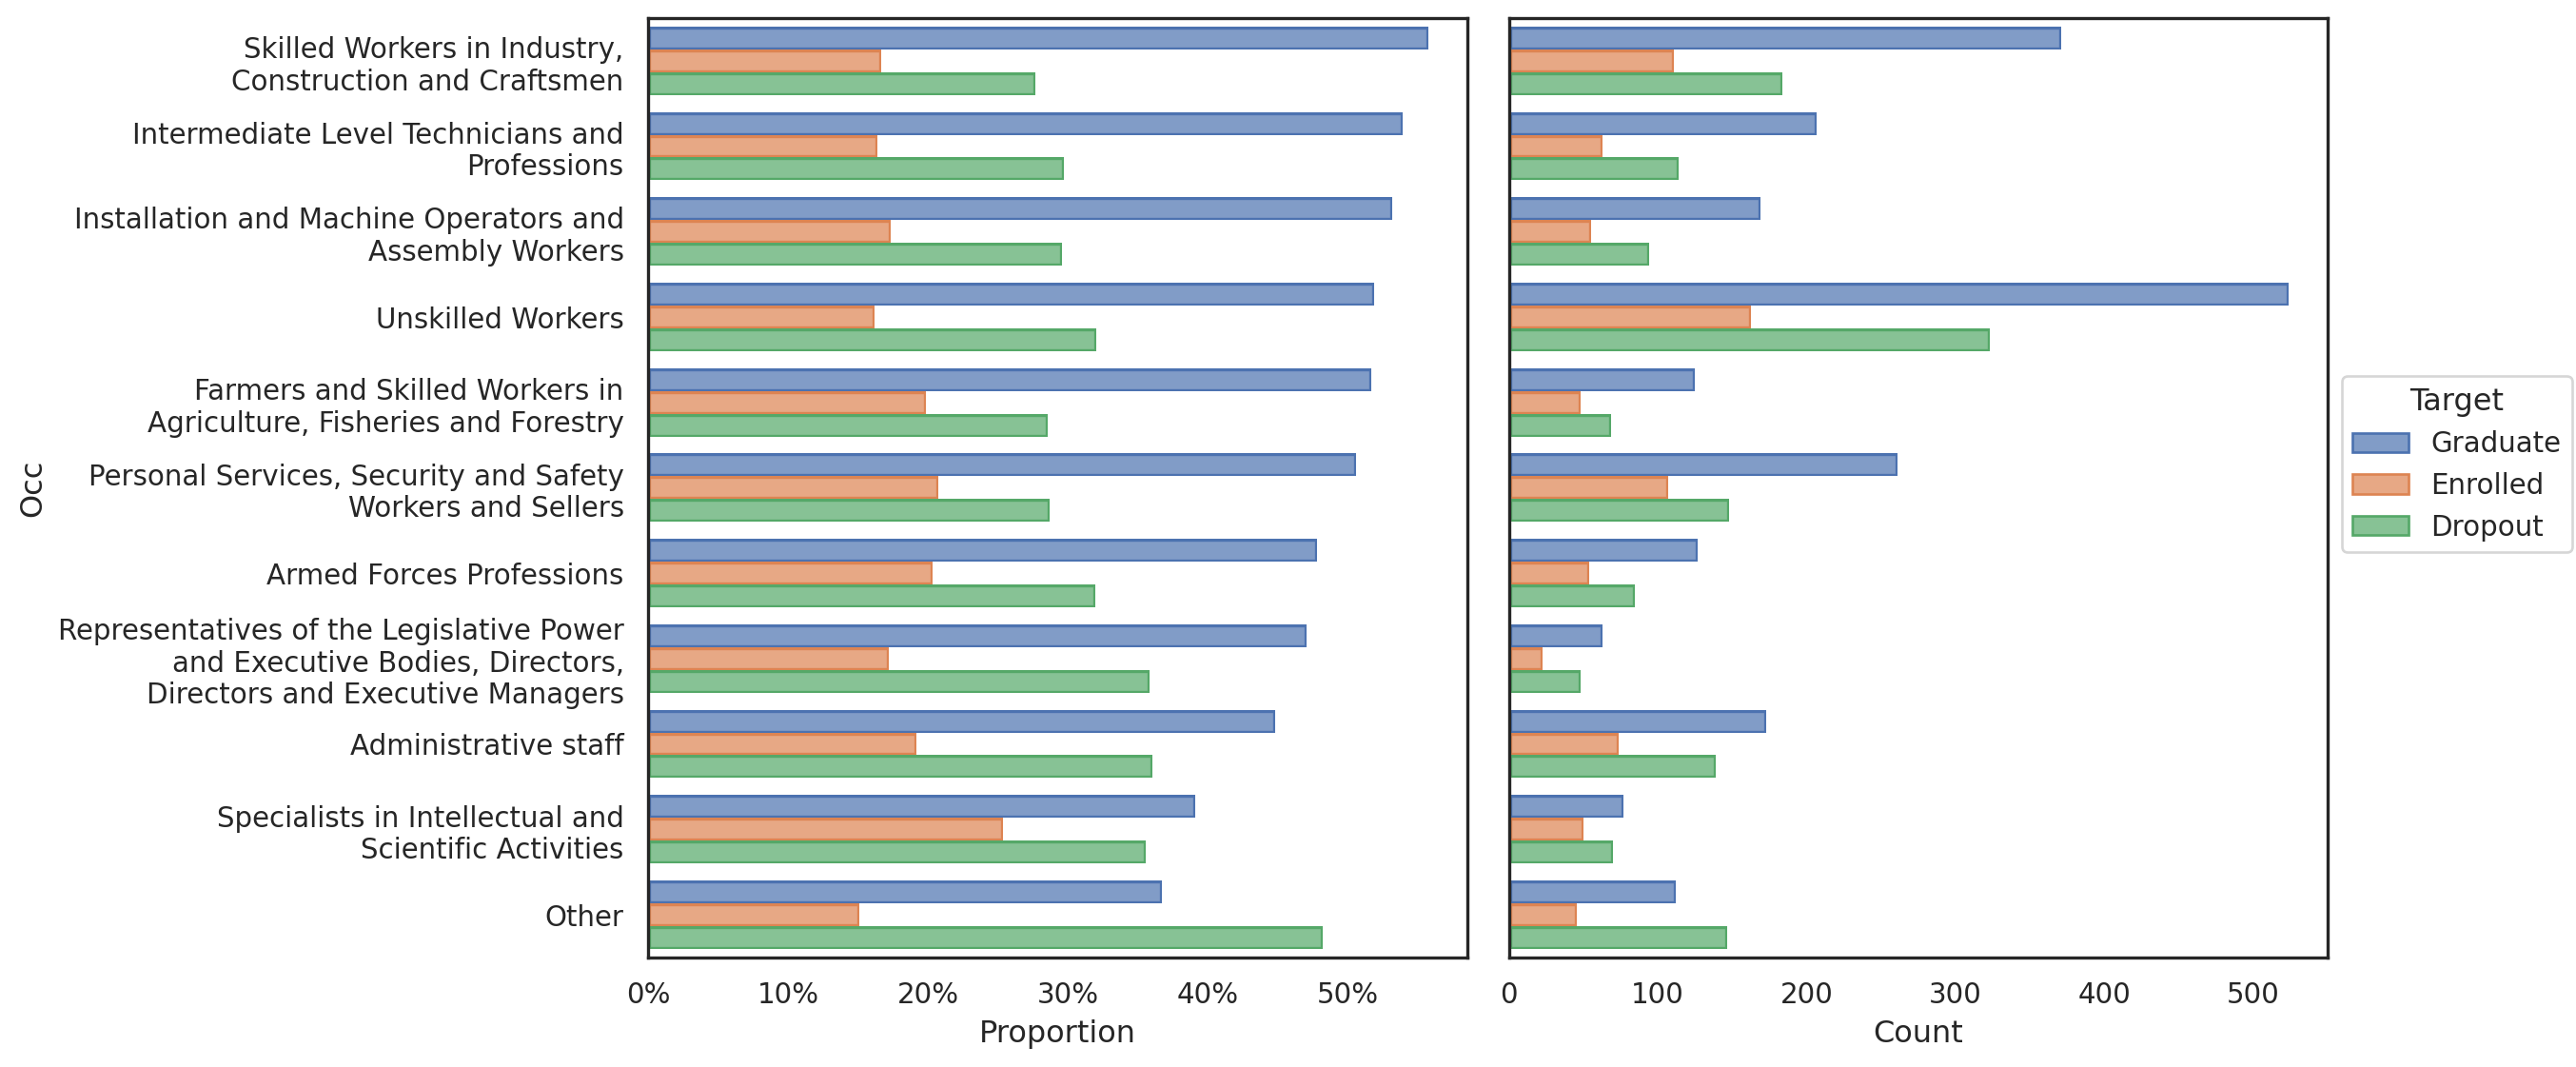

In [58]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["father's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

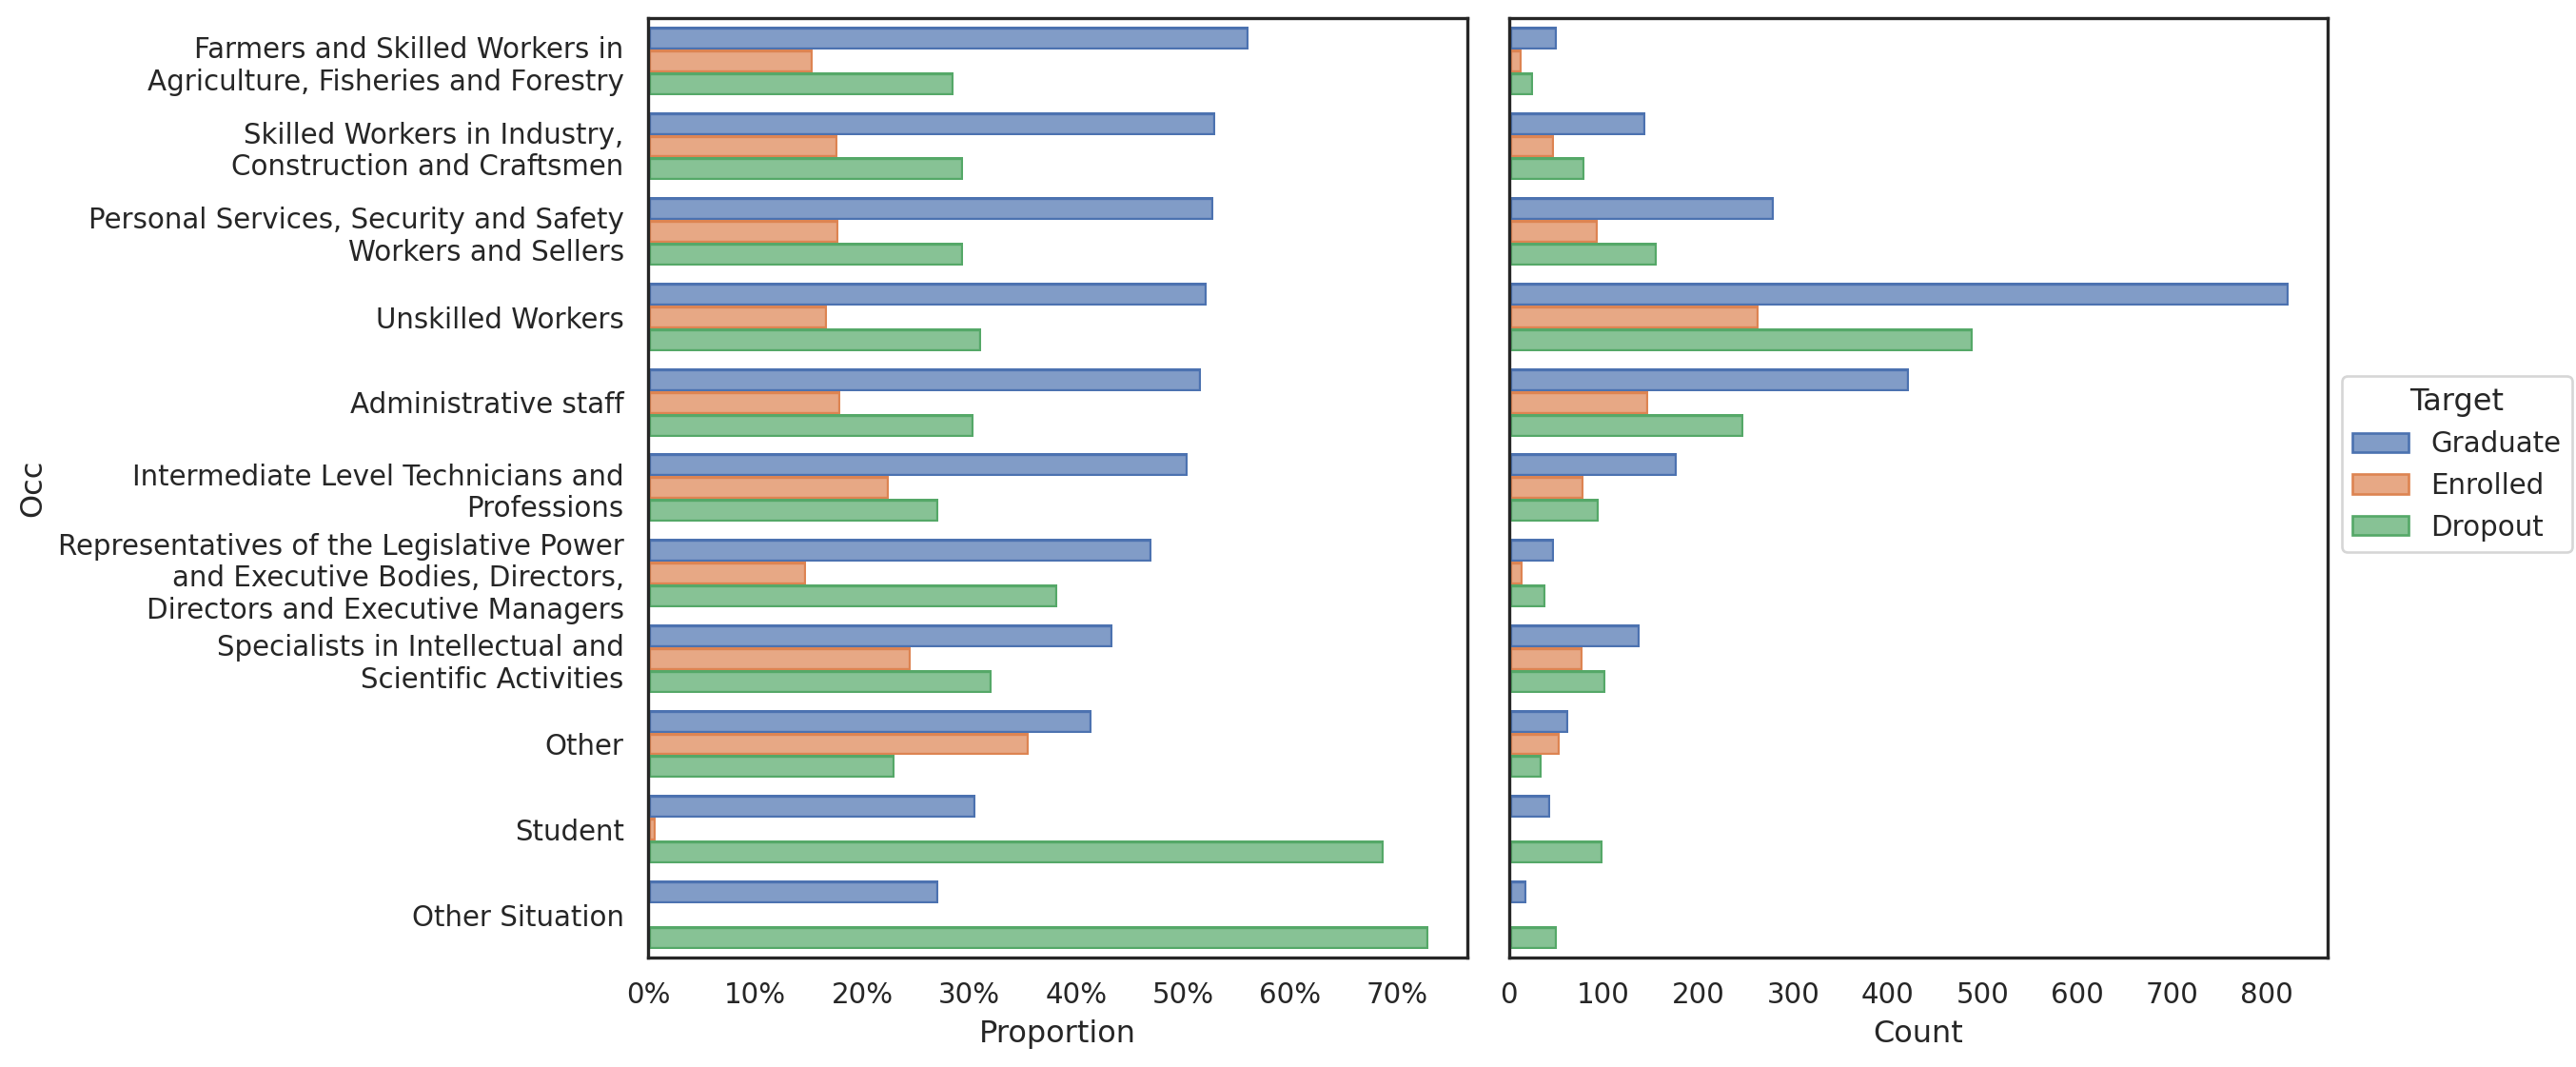

In [59]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["mother's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

In [63]:
parents_occupation = pd.concat([students["mother's_occupation"], students["father\'s_occupation"]])
parents_occupation.value_counts().head(15)

Unskilled Workers                                                                                             2587
Administrative staff                                                                                          1203
Personal Services, Security and Safety Workers and Sellers                                                    1046
Skilled Workers in Industry, Construction and Craftsmen                                                        938
Intermediate Level Technicians and Professions                                                                 735
Specialists in Intellectual and Scientific Activities                                                          515
Installation and Machine Operators and Assembly Workers                                                        354
Farmers and Skilled Workers in Agriculture, Fisheries and Forestry                                             333
Student                                                                         

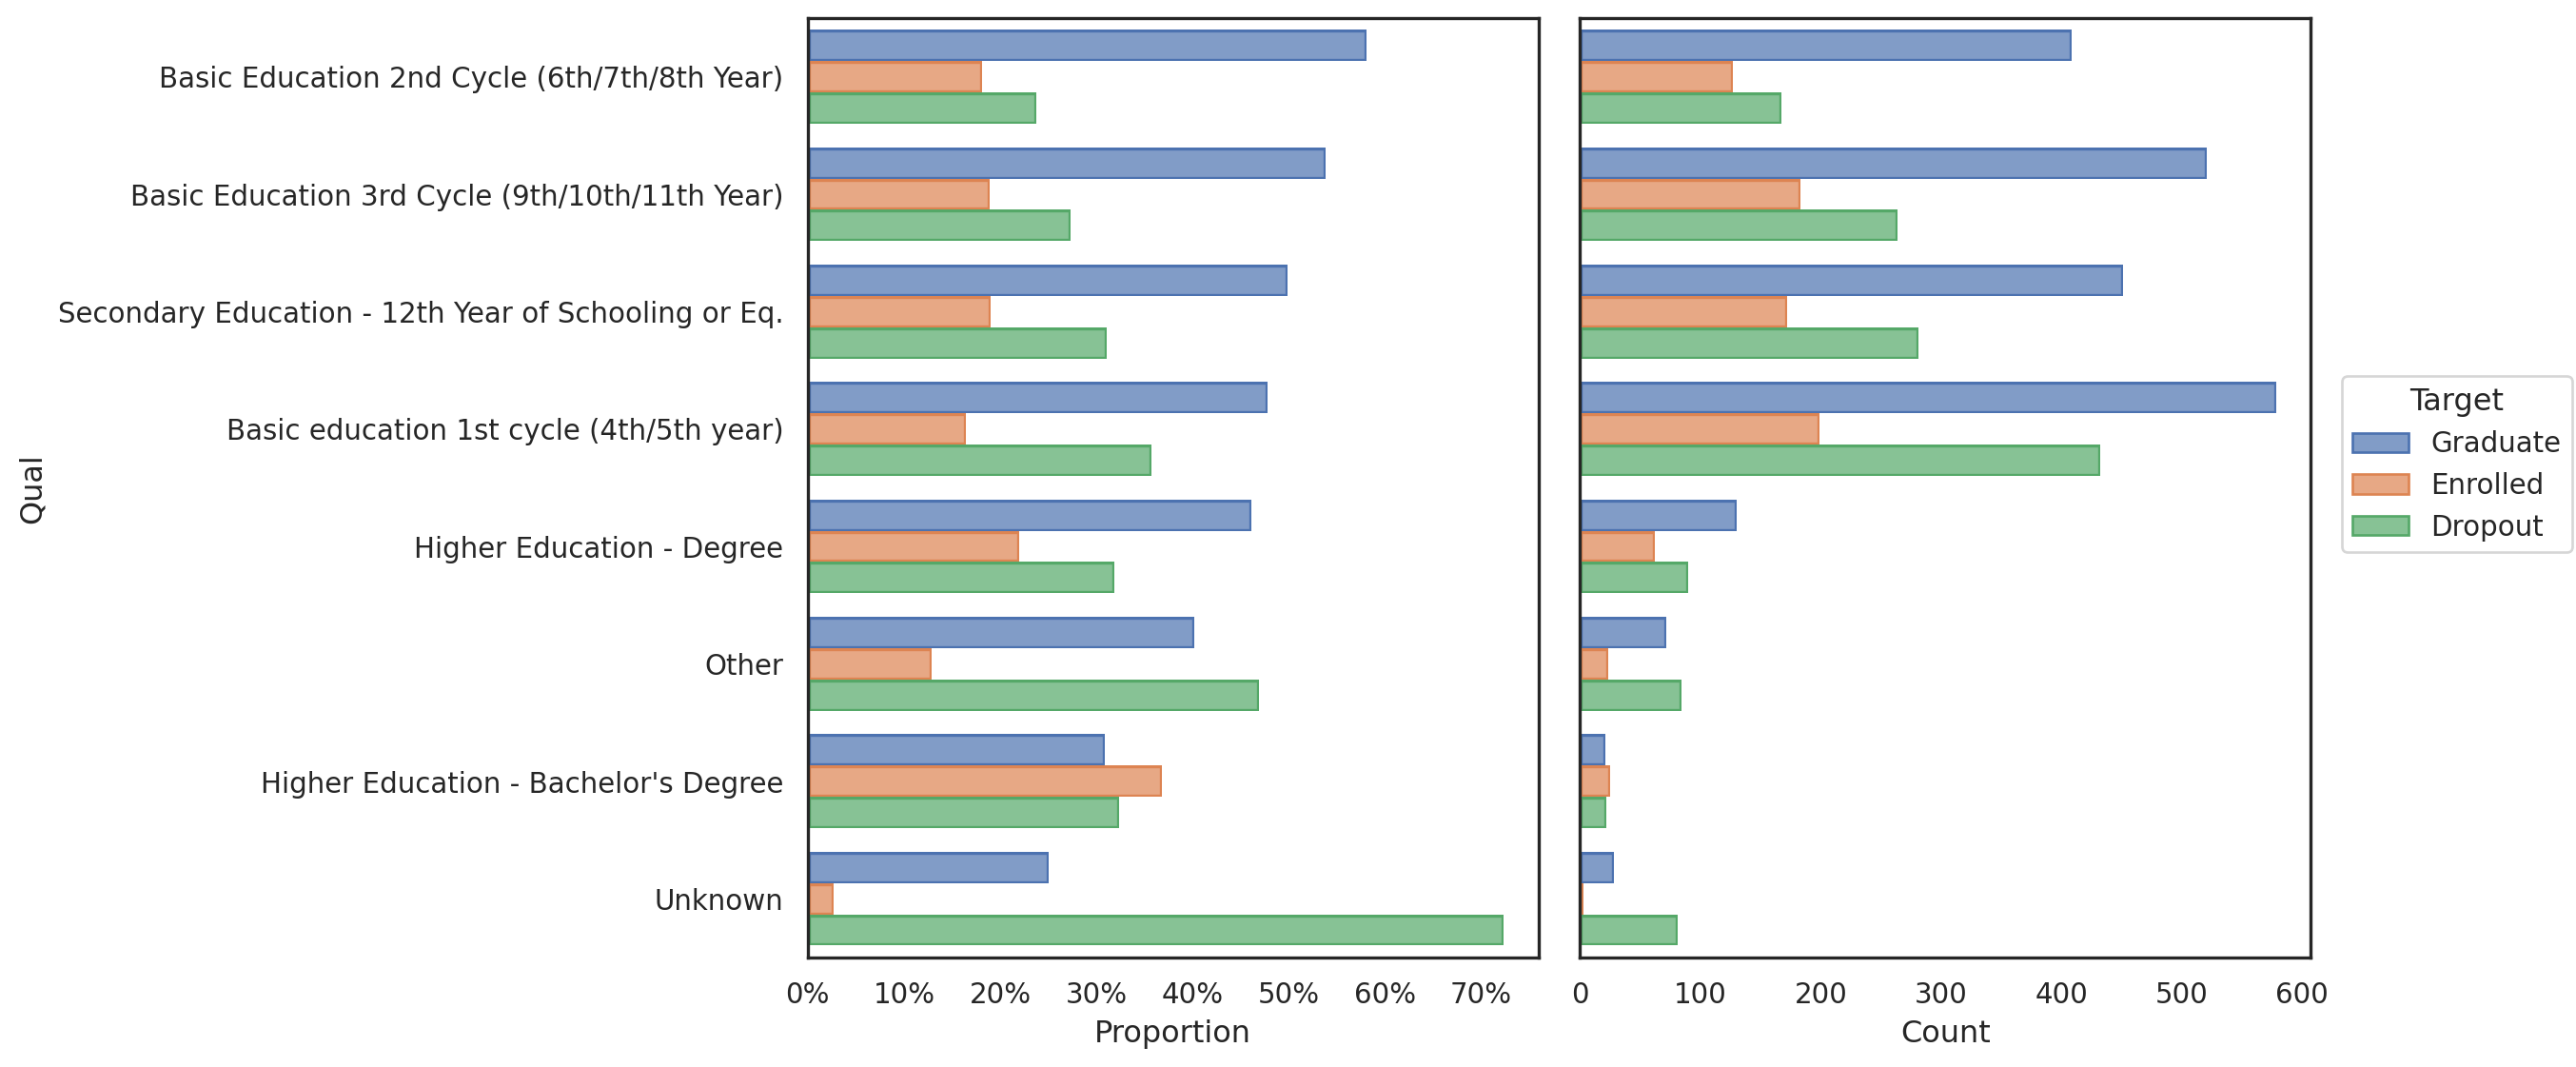

In [66]:
students.assign(qual = lambda x:fct_lump(x["father's_qualification"],7)).pipe(plot_proportions, "qual")

In [64]:
parents_qualification = pd.concat([students["mother\'s_qualification"], students["father\'s_qualification"]])
parents_qualification.value_counts().head(15)

Secondary Education - 12th Year of Schooling or Eq.    1973
Basic education 1st cycle (4th/5th year)               1213
General Course of Administration and Commerce          1010
Basic Education 3rd Cycle (9th/10th/11th Year)          969
General commerce course                                 954
Higher Education - Degree                               720
Basic Education 2nd Cycle (6th/7th/8th Year)            706
Supplementary Accounting and Administration             563
Higher Education - Bachelor's Degree                    151
2nd cycle of the general high school course             131
Unknown                                                 120
Higher Education - Master's                              88
Other - 11th Year of Schooling                           80
Higher Education - Doctorate                             39
Technological specialization course                      21
dtype: int64

It doesn't seems like the level of education of the parents or their job makes great difference in their children studies success. There seems to be a little negative correlation between success in studies and parents salaries and qualifications. Maybe this occurs because students with higher income parents are more likely to go to high level universities, and these are harder to approve? I 

<AxesSubplot: xlabel='age_at_enrollment', ylabel='Density'>

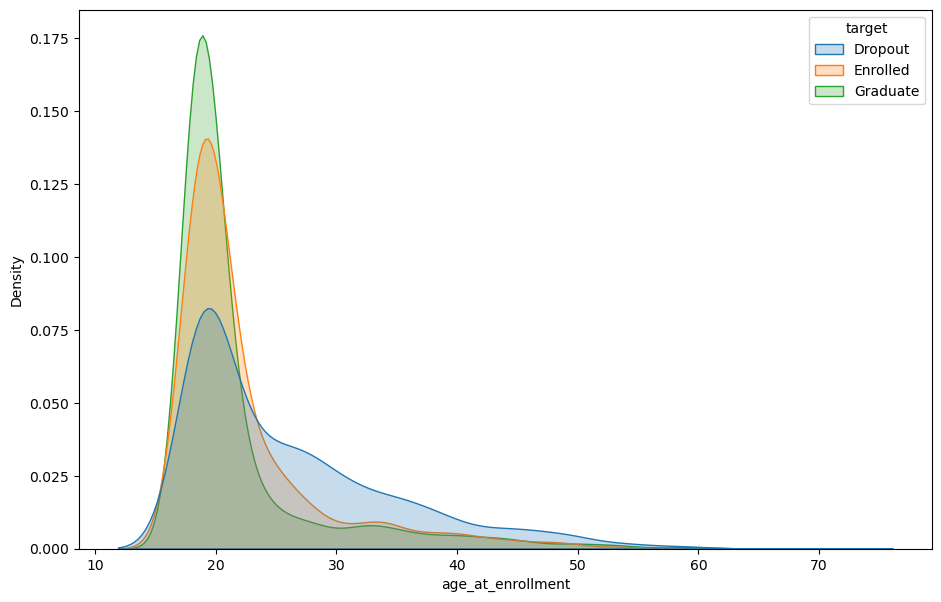

In [158]:
sns.kdeplot(students, x = "age_at_enrollment", hue = "target", fill = True, common_norm=False)

<AxesSubplot: xlabel='unemployment_rate', ylabel='Count'>

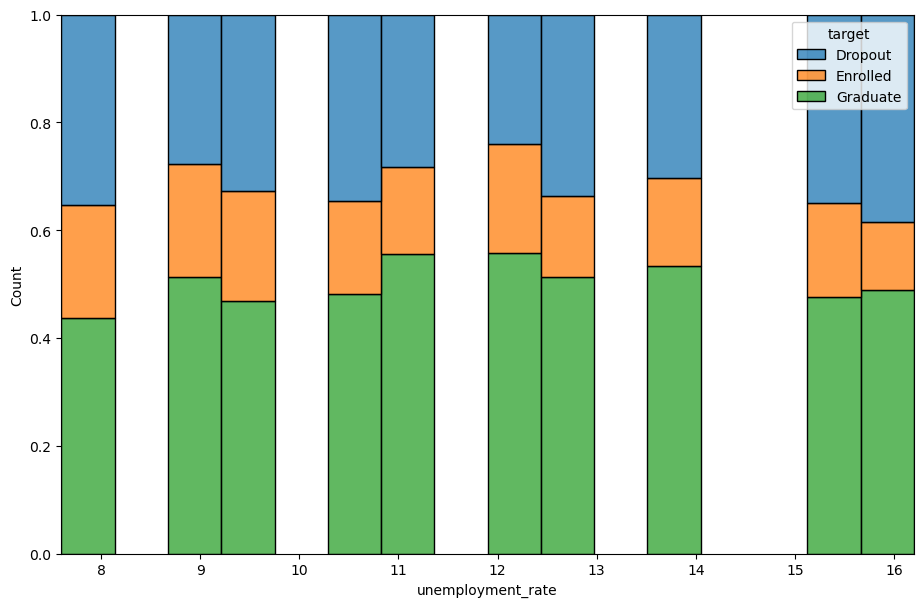

In [74]:
sns.histplot(students, x = "unemployment_rate", hue = "target", stat= "count", multiple="fill")

<AxesSubplot: xlabel='gdp', ylabel='Count'>

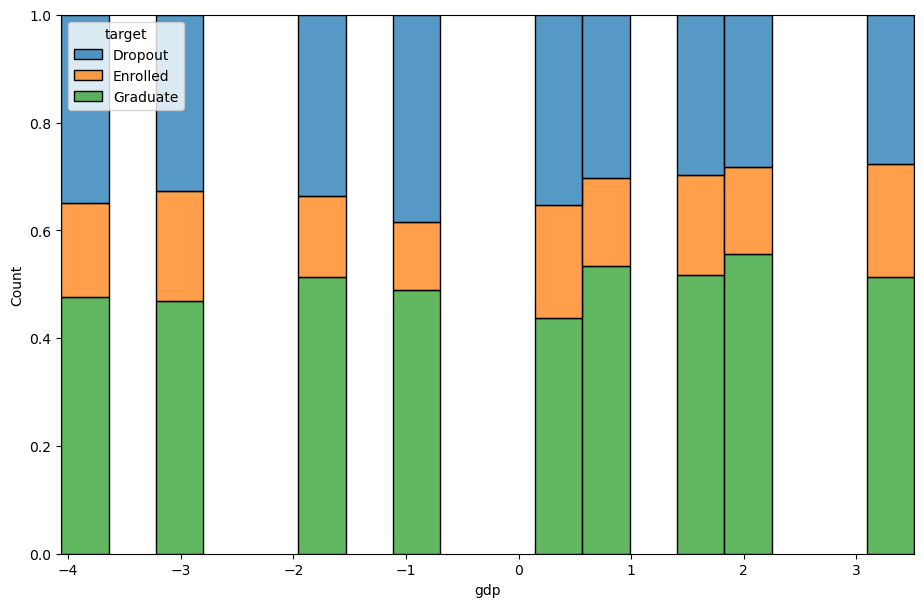

In [75]:
sns.histplot(students, x = "gdp", hue = "target", stat= "count", multiple="fill")

<AxesSubplot: xlabel='inflation_rate', ylabel='Count'>

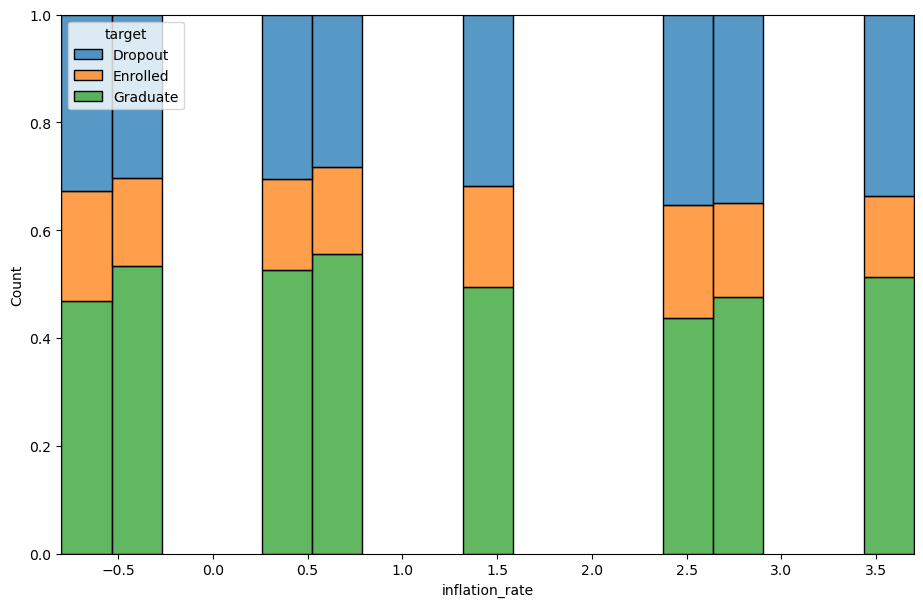

In [76]:
sns.histplot(students, x = "inflation_rate", hue = "target", stat= "count", multiple="fill")

### Visualize academic data

In [85]:
academic_columns = students.columns[students.columns.str.contains("curricular")]
students[academic_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
curricular_units_1st_sem_(credited),4424.0,0.709991,2.360507,0.0,0.00,0.000000,0.000000,20.000000
curricular_units_1st_sem_(enrolled),4424.0,6.270570,2.480178,0.0,5.00,6.000000,7.000000,26.000000
curricular_units_1st_sem_(evaluations),4424.0,8.299051,4.179106,0.0,6.00,8.000000,10.000000,45.000000
curricular_units_1st_sem_(approved),4424.0,4.706600,3.094238,0.0,3.00,5.000000,6.000000,26.000000
curricular_units_1st_sem_(grade),4424.0,10.640822,4.843663,0.0,11.00,12.285714,13.400000,18.875000
curricular_units_1st_sem_(without_evaluations),4424.0,0.137658,0.690880,0.0,0.00,0.000000,0.000000,12.000000
curricular_units_2nd_sem_(credited),4424.0,0.541817,1.918546,0.0,0.00,0.000000,0.000000,19.000000
curricular_units_2nd_sem_(enrolled),4424.0,6.232143,2.195951,0.0,5.00,6.000000,7.000000,23.000000
curricular_units_2nd_sem_(evaluations),4424.0,8.063291,3.947951,0.0,6.00,8.000000,10.000000,33.000000
curricular_units_2nd_sem_(approved),4424.0,4.435805,3.014764,0.0,2.00,5.000000,6.000000,20.000000


In [92]:
first_semester_evals = students[["curricular_units_1st_sem_(evaluations)", "curricular_units_1st_sem_(approved)", "target"]]
first_semester_evals.columns = ["evaluations", "approved", "target"]

In [93]:
first_semester_evals.assign(bigger = lambda x: x.evaluations >= x.approved).query("bigger")
# All numbers are valid

,evaluations,approved,target,bigger
0,0,0,Dropout,True
1,6,6,Graduate,True
2,0,0,Dropout,True
3,8,6,Graduate,True
4,9,5,Graduate,True
...,...,...,...,...
4419,7,5,Graduate,True
4420,6,6,Dropout,True
4421,8,7,Dropout,True
4422,5,5,Graduate,True


In [96]:
first_semester_evals = first_semester_evals.assign(pct_approved = lambda x: x.approved / x.evaluations).query("evaluations > 5")

<AxesSubplot: xlabel='evaluations', ylabel='pct_approved'>

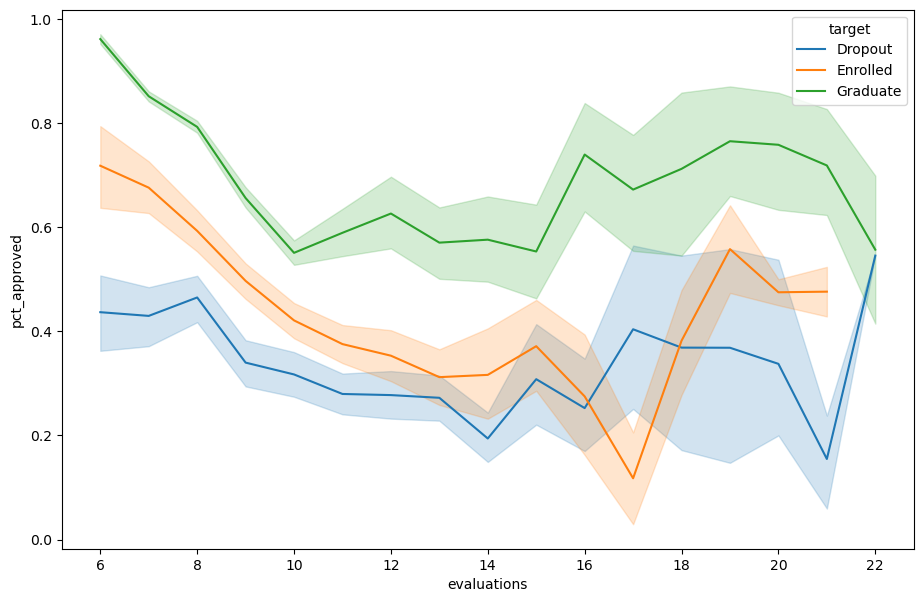

In [99]:
sns.lineplot(first_semester_evals.query("evaluations <= 22"), x = "evaluations", y = "pct_approved", hue = "target")

This one looks like a really good predictor, there is a clear difference between students who graduate on time and the others, and this is just information from the first semester of the course! Lets check the second semester